In [1]:
#@title Imports
!pip install -U -q keras-tuner
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from collections import defaultdict
from sklearn.model_selection import TimeSeriesSplit
import gc
import imageio
import tqdm
import IPython
import datetime
from time import sleep
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import kerastuner as kt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML
import pickle as pkl

display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('ggplot')

     |████████████████████████████████| 61kB 5.7MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
seed = 7
np.random.seed(seed=seed)
tf.random.set_seed(seed)

In [5]:
#@title plots
def plot_history_model(history):
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    ax = axs.flatten()
    # losses
    ax[0].set_title('Loss')
    ax[0].plot(history.history['loss'], label='train loss');
    ax[0].plot(history.history['val_loss'], label='val loss');
    # metrics
    ax[1].set_title('Metrics')
    ax[1].plot(history.history['mean_absolute_error'], label='train abs error');
    ax[1].plot(history.history['val_mean_absolute_error'], label='test abs error');
    ax[0].legend(), ax[1].legend()
    plt.show(); 

def plot_train(history, title):
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    axes = ax.flatten()
    axes[1].set_title(title)
    axes[1].plot(history.history['mean_absolute_error'], label='train MAE')
    axes[1].set_xlabel('epochs'), axes[1].set_ylabel('Casos')
    axes[0].plot(history.history['loss'], label='train MSE')
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('Error')
    axes[0].set_title(title)
    axes[0].legend(), axes[1].legend()
    plt.show()   

def plot_forecasting(dataset_test, point_date_predict, df_join, predictions, window_size, future_steps, smooth):
    tem = df_join.loc[(df_join.index>=point_date_predict)]['Bucaramanga'].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False)
    history = df_join.loc[(df_join.index<point_date_predict)]['Bucaramanga'].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False)
    for k, (x, y) in enumerate(dataset_test):
        fig = plt.figure(figsize=(18,6))
        present_dates = tem.iloc[k:(window_size+k)].index
        future_dates = tem.iloc[(window_size+k):(window_size+k)+future_steps].index
        plt.plot(history.index, history.values, c='blue', label='Valores de ajuste')
        plt.plot(present_dates, x.numpy().flatten(), label='Ventana presente')#
        plt.plot(future_dates, y.numpy().flatten(), label='Valores futuros')# 
        if True:#k%window_size==0:
            prediction = predictions[k,:]
        plt.scatter(future_dates, prediction.flatten(), label='Valores predichos')
        plt.legend()
        plt.title('Fecha {} paso {}'.format(k, present_dates[-1]))
        plt.axis([None, None, 0, 350])
        fig.savefig('{}.png'.format(k), format='png', dpi=300, bbox_inches = 'tight', pad_inches = 0) 
        plt.show()
        sleep(0.5)
        IPython.display.clear_output(wait=True)  
    #imageio.mimsave("forecasting_{}.gif".format(point_date_predict), figures)
          

### A nivel de Países

In [8]:
# Leer datos de todas las series temporales sobre covid
data = pd.read_excel('/content/drive/My Drive/Datos/Alcaldia/Analitica/Modelo_datos/owid-covid-data.xlsx')

In [9]:
timeline = sorted(np.unique(data.date.astype('datetime64[ns]')))

In [10]:
# Consultar solo valores de interes (paises y variables)
data_selected = data.loc[(~data.iso_code.isna())&(data.iso_code!='OWID_WRL'),
                    ['iso_code','continent','location', 'date', 'new_cases', 'new_cases_smoothed', 'new_deaths' , 'new_deaths_smoothed']]
data_selected.head()    

,iso_code,continent,location,date,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed
0,AFG,Asia,Afghanistan,2019-12-31,0.0,NaN,0.0,NaN
1,AFG,Asia,Afghanistan,2020-01-01,0.0,NaN,0.0,NaN
2,AFG,Asia,Afghanistan,2020-01-02,0.0,NaN,0.0,NaN
3,AFG,Asia,Afghanistan,2020-01-03,0.0,NaN,0.0,NaN
4,AFG,Asia,Afghanistan,2020-01-04,0.0,NaN,0.0,NaN


In [11]:
# analizar la cantidad de registros por cada país y agruparlos por cantidad
country_freq = data_selected.groupby(['location']).agg({'date':'count'}).rename(columns={'date':'num_records'})

In [12]:
# analizar los registros por cada país y seleccionar los países que tengan el mismo numero de mayor registros
records, counts = np.unique(country_freq.num_records.values, return_counts=True)
print('Max group of records {}'.format(max(counts)))
print('Order by num of records {}'.format(list(zip(records[np.argsort(counts)][::-1], counts[np.argsort(counts)][::-1]))))

Max group of records 63
Order by num of records [(306, 63), (231, 12), (226, 11), (232, 8), (225, 8), (227, 7), (228, 7), (233, 6), (224, 5), (236, 5), (235, 4), (240, 4), (229, 4), (238, 4), (239, 4), (223, 4), (219, 3), (214, 3), (237, 3), (242, 3), (230, 3), (247, 2), (249, 2), (221, 2), (220, 2), (305, 2), (241, 2), (234, 2), (222, 2), (268, 2), (189, 1), (206, 1), (205, 1), (250, 1), (184, 1), (183, 1), (211, 1), (170, 1), (58, 1), (16, 1), (15, 1), (209, 1), (304, 1), (213, 1), (215, 1), (217, 1), (218, 1), (276, 1), (269, 1), (258, 1), (243, 1), (244, 1), (245, 1), (3, 1)]


In [13]:
# Armar la estructura para casos nuevos
data_to_use = defaultdict(list)
for index, row in data_selected.iterrows(): # use data tem to less countries
    data_to_use[row.location].append(row.new_cases_smoothed)#new_cases_smoothed

In [14]:
# hacer padding a cada lista del dict # 294 es el maximo
final_dict = dict()
for country in data_to_use.keys():
    diff = 306-len(data_to_use[country])
    final_dict[country] = [0.0]*diff + data_to_use[country]
del data_to_use   

In [15]:
data_to_use = pd.DataFrame(final_dict)

In [16]:
data_to_use['date'] = timeline

In [17]:
data_to_use.set_index('date', inplace=True)

In [18]:
# llenar los nan hacia atras
data_to_use.fillna(axis=0, method='backfill', inplace=True)

In [19]:
data_to_use

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bonaire Sint Eustatius and Saba,Bosnia and Herzegovina,Botswana,Brazil,British Virgin Islands,Brunei,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Cayman Islands,Central African Republic,Chad,...,Slovenia,Solomon Islands,Somalia,South Africa,South Korea,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Swaziland,Sweden,Switzerland,Syria,Taiwan,Tajikistan,Tanzania,Thailand,Timor,Togo,Trinidad and Tobago,Tunisia,Turkey,Turks and Caicos Islands,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-01,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-02,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-03,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-04,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,106.429,299.286,257.571,100.286,251.286,0.0,0.714,14234.143,2135.714,12.286,18.286,2633.857,741.571,99.000,329.857,1435.000,1.571,773.857,14720.000,52.429,8.714,1.143,1.714,151.714,0.000,990.714,96.286,22732.429,0.0,0.143,1372.143,10.286,1.143,0.429,41.000,2682.286,89.000,0.571,1.000,7.286,..

### Selección de países

In [20]:
contries_top = data_to_use.keys()[(data_to_use.sum()>=184000).values].values.tolist()
# Quitar Colombia de la lista
contries_top.pop(contries_top.index('Colombia'))

'Colombia'

## Leer datos de Colombia

In [21]:
data_colombia = pd.read_csv('/content/drive/My Drive/Datos/Alcaldia/Analitica/Modelo_datos/Casos_positivos_de_COVID-19_en_Colombia.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
data_colombia.head()

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1,F,Importado,Casa,Leve,380.0,ITALIA,Recuperado,27/2/2020 0:00:00,NaN,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6.0,NaN
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1,M,Importado,Casa,Leve,724.0,ESPAÑA,Recuperado,4/3/2020 0:00:00,NaN,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5.0,NaN
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1,F,Importado,Casa,Leve,724.0,ESPAÑA,Recuperado,29/2/2020 0:00:00,NaN,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6.0,NaN
3,11/3/2020 0:00:00,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,6/3/2020 0:00:00,NaN,11/3/2020 0:00:00,26/3/2020 0:00:00,PCR,6.0,NaN
4,11/3/2020 0:00:00,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,8/3/2020 0:00:00,NaN,11/3/2020 0:00:00,23/3/2020 0:00:00,PCR,6.0,NaN


In [23]:
# encontrar numero de casos por departamento
df_freq_dep = data_colombia.groupby(['Nombre departamento']).count()['Fecha de notificación'].to_frame().rename(columns={'Fecha de notificación':'Casos'})

In [24]:
# solo tomo los departamentos mayores al promedio
departamentos_iniciales = df_freq_dep.loc[df_freq_dep.Casos>df_freq_dep.Casos.mean()].index.values.tolist()

In [25]:
departamentos_iniciales.pop(departamentos_iniciales.index('BARRANQUILLA'))

'BARRANQUILLA'

In [26]:
departamentos_iniciales.pop(departamentos_iniciales.index('BOGOTA'))

'BOGOTA'

In [27]:
departamentos_iniciales

['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']

In [28]:
# encontrar numero de casos por ciudad
df_freq = data_colombia.groupby(['Nombre municipio']).count()['Fecha de notificación'].to_frame().rename(columns={'Fecha de notificación':'Casos'})

In [29]:
# Solo tomar los que tiene mas casos que Bucaramanga
ciudades_iniciales = df_freq.loc[df_freq.Casos>=df_freq.loc[df_freq.index=='BUCARAMANGA'].values[0][0]].index.values.tolist() 

In [30]:
data_colombia_main_ciudades = data_colombia.loc[data_colombia['Nombre municipio'].isin(ciudades_iniciales)].groupby(['Nombre municipio', 
                                                                                          'Fecha de notificación']).agg({'Fecha de notificación':'count'}).rename(columns={'Fecha de notificación': 'cases'})

In [31]:
data_colombia_main_dep = data_colombia.loc[(data_colombia['Nombre departamento'].isin(departamentos_iniciales))].groupby(['Nombre departamento', 
                                                                                          'Fecha de notificación']).agg({'Fecha de notificación':'count'}).rename(columns={'Fecha de notificación': 'cases'})

In [32]:
data_colombia_main_dep

cases
Nombre departamento Fecha de notificación       
ANTIOQUIA           1/10/2020 0:00:00       1541
                    1/4/2020 0:00:00           9
                    1/5/2020 0:00:00           5
                    1/6/2020 0:00:00          60
                    1/7/2020 0:00:00         493
...                                          ...
VALLE               9/5/2020 0:00:00          65
                    9/6/2020 0:00:00         296
                    9/7/2020 0:00:00         517
                    9/8/2020 0:00:00         272
                    9/9/2020 0:00:00         541

[1105 rows x 1 columns]

In [33]:
data_colombia_main_ciudades = data_colombia_main_ciudades.cases.unstack().T.fillna(axis=0, method='backfill', inplace=False)
data_colombia_main_dep = data_colombia_main_dep.cases.unstack().T.fillna(axis=0, method='backfill', inplace=False)

In [34]:
data_colombia_main = data_colombia_main_ciudades.join(data_colombia_main_dep)
data_colombia_main

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE
Fecha de notificación,,,,,,,,,,,
1/10/2020 0:00:00,59.0,2004.0,122.0,430.0,48.0,907.0,1541.0,47.0,222.0,363.0,638.0
1/4/2020 0:00:00,8.0,113.0,4.0,24.0,4.0,6.0,9.0,2.0,7.0,15.0,26.0
1/5/2020 0:00:00,42.0,129.0,4.0,16.0,20.0,3.0,5.0,79.0,2.0,15.0,17.0
1/6/2020 0:00:00,321.0,489.0,4.0,144.0,104.0,23.0,60.0,192.0,71.0,15.0,242.0
1/7/2020 0:00:00,682.0,2177.0,7.0,432.0,392.0,250.0,493.0,500.0,237.0,48.0,574.0
...,...,...,...,...,...,...,...,...,...,...,...
9/5/2020 0:00:00,59.0,210.0,4.0,44.0,74.0,4.0,7.0,96.0,10.0,24.0,65.0
9/6/2020 0:00:00,494.0,591.0,4.0,235.0,175.0,39.0,83.0,287.0,74.0,24.0,296.0
9/7/2020 0:00:00,439.0,2205.0,50.0,424.0,268.0,775.0,1265.0,368.0,266.0,103.0,517.0


In [35]:
#data_colombia_main['date'] = data_colombia_main.index.astype('datetime64[ns]') 
data_colombia_main['date'] = pd.to_datetime(data_colombia_main.index, infer_datetime_format=False, format='%d/%m/%Y %H:%M:%S')
data_colombia_main.set_index('date', inplace=True)
data_colombia_main

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE
date,,,,,,,,,,,
2020-10-01,59.0,2004.0,122.0,430.0,48.0,907.0,1541.0,47.0,222.0,363.0,638.0
2020-04-01,8.0,113.0,4.0,24.0,4.0,6.0,9.0,2.0,7.0,15.0,26.0
2020-05-01,42.0,129.0,4.0,16.0,20.0,3.0,5.0,79.0,2.0,15.0,17.0
2020-06-01,321.0,489.0,4.0,144.0,104.0,23.0,60.0,192.0,71.0,15.0,242.0
2020-07-01,682.0,2177.0,7.0,432.0,392.0,250.0,493.0,500.0,237.0,48.0,574.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,59.0,210.0,4.0,44.0,74.0,4.0,7.0,96.0,10.0,24.0,65.0
2020-06-09,494.0,591.0,4.0,235.0,175.0,39.0,83.0,287.0,74.0,24.0,296.0
2020-07-09,439.0,2205.0,50.0,424.0,268.0,775.0,1265.0,368.0,266.0,103.0,517.0


## Sincronización de secuencias

In [36]:
# unir los datos de todas las series
df_join = data_to_use[contries_top].join(data_colombia_main)

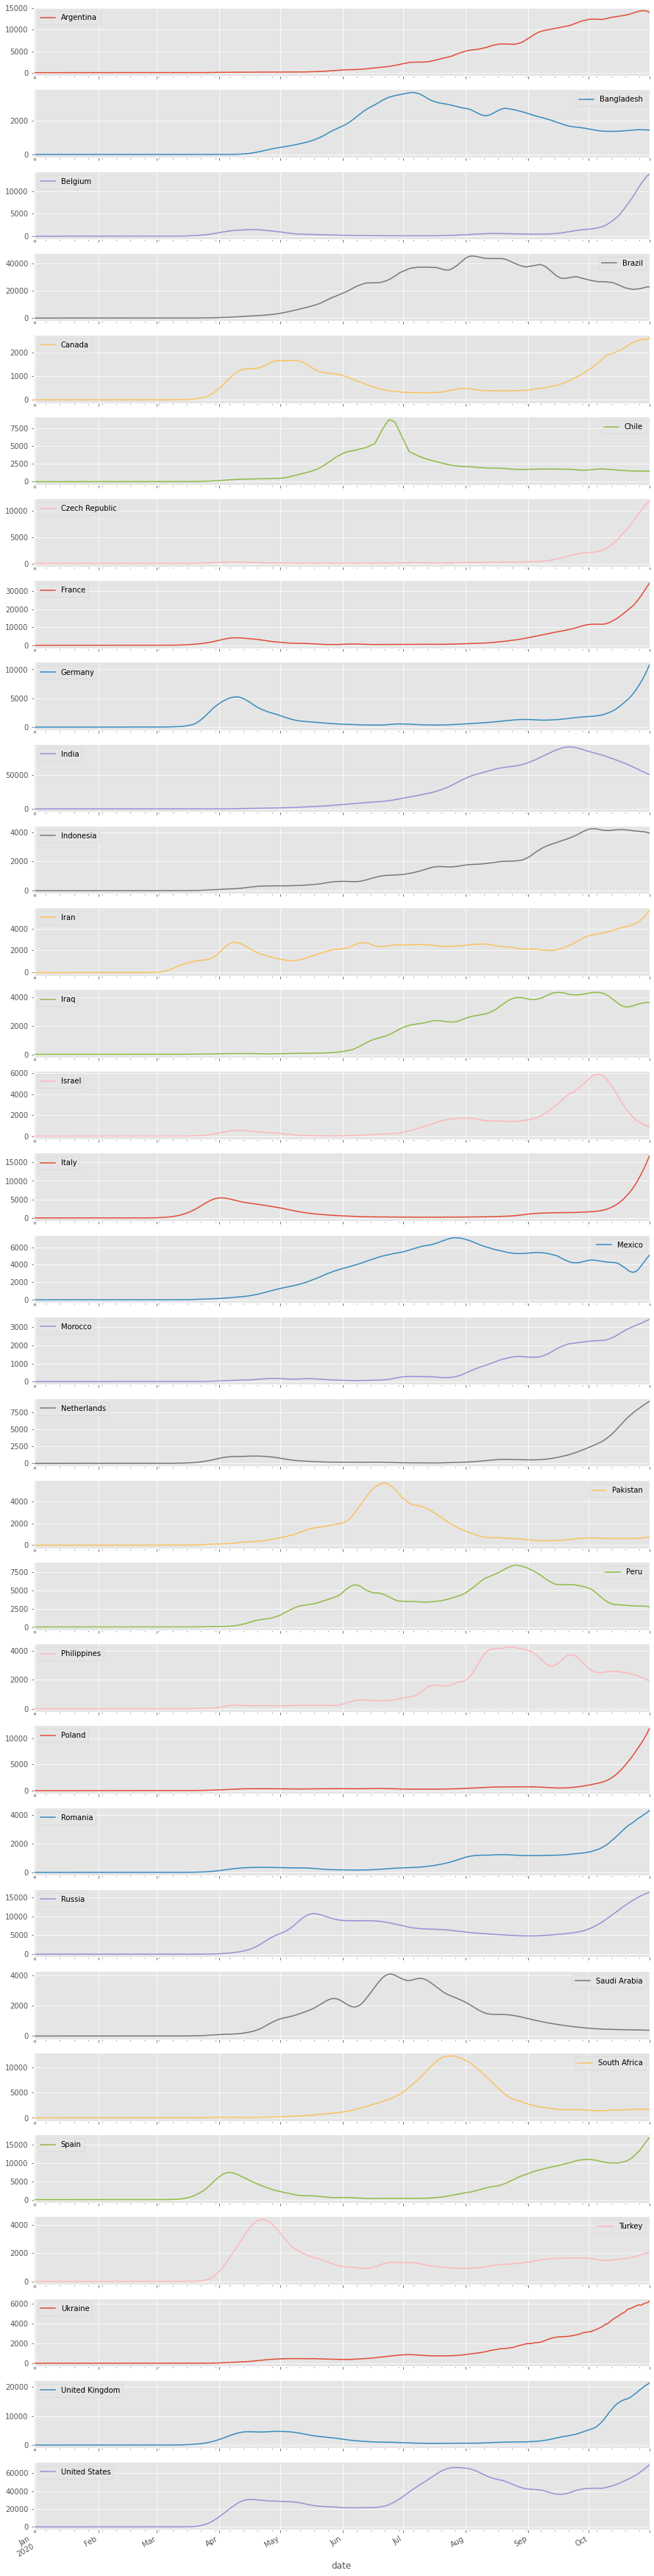

In [37]:
smooth = 10
df_join[contries_top].iloc[:,:].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False).plot(subplots=True, figsize=(15,70));

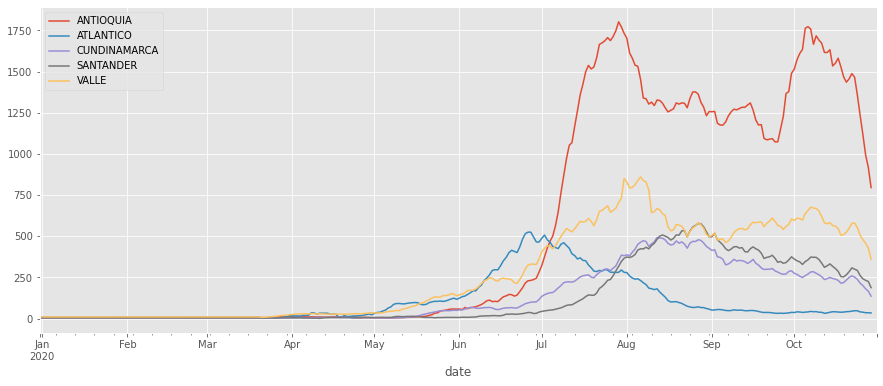

In [38]:
df_join[departamentos_iniciales].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False).plot(figsize=(15,6));

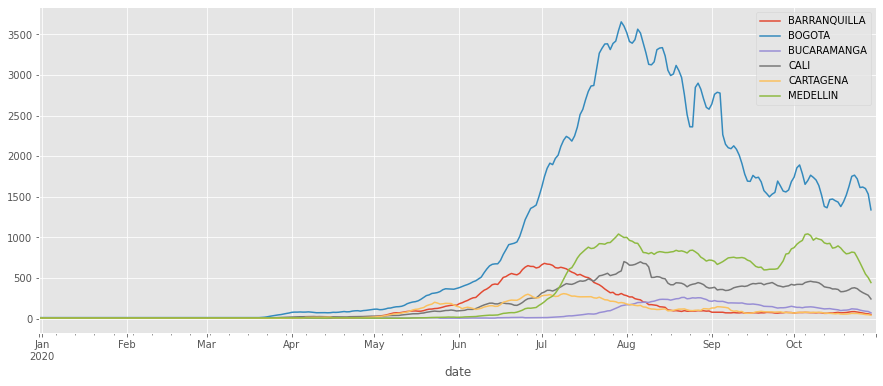

In [39]:
df_join[ciudades_iniciales].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False).plot(figsize=(15,6));

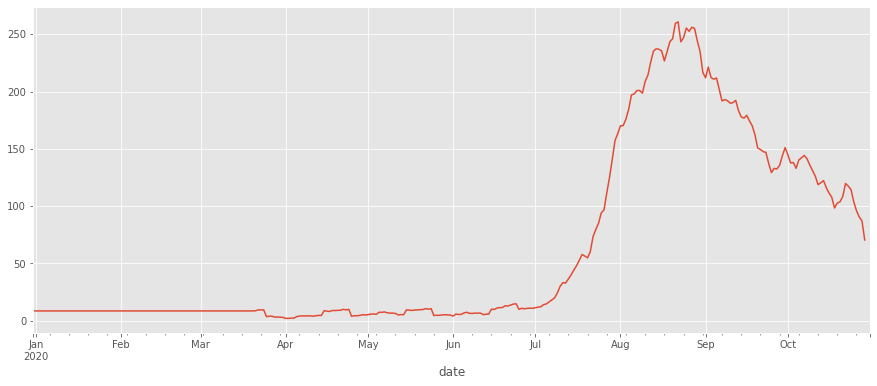

In [40]:
df_join['BUCARAMANGA'].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False).plot(figsize=(15,6));

## Análitica inicial 

In [41]:
# parametros compartidos
# tamaño de la ventana
window_size = 21
# número de batches
batch_size = 1
# número de días a predecir
future_steps = 14
# usar stateful en los modelos
stateful = False
# estandrizar las series temporales
standarization = False
# diferenciar las series con un determinado lag
differentiation, lag = False, 1
# suavizar las series temporales 
smoothing, smooth = False, 7
# rango de fechas para seleccionar las series
initial_date = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d') 
final_date = datetime.datetime.strptime('2020-10-29', '%Y-%m-%d')
# rango de fechas para entrenar y testear (última ventana futura más 7 días)
train_final_date = datetime.datetime.strptime('2020-09-18', '%Y-%m-%d')

In [42]:
#@title Funciones para analizar las series | Créditos:github.com/madagra/
class TargetTransformer:
    """
    Perform some transformation on the time series
    data in order to make the model more performant and
    avoid non-stationary effects.
    """
        
    def __init__(self, log=False, detrend=False, diff=False):
        
        self.trf_log = log
        self.trf_detrend = detrend
        self.trend = pd.Series(dtype=np.float64)
    
    def transform(self, index, values):
        """
        Perform log transformation to the target time series

        :param index: the index for the resulting series
        :param values: the values of the initial series

        Return:
            transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_detrend:
            self.trend = TargetTransformer.get_trend(res) - np.mean(res.values)
            res = res.subtract(self.trend)
            
        if self.trf_log:
            res = pd.Series(index=index, data=np.log(res.values))
        
        return res
    
    def inverse(self, index, values):
        """
        Go back to the original time series values

        :param index: the index for the resulting series
        :param values: the values of series to be transformed back

        Return:
            inverse transformed pd.Series
        """        
        res = pd.Series(index=index, data=values)
        
        if self.trf_log:
            res = pd.Series(index=index, data=np.exp(values))
        try:
            if self.trf_detrend:
                assert len(res.index) == len(self.trend.index)                
                res = res + self.trend
                
        except AssertionError:
            print("Use a different transformer for each target to transform")
            
        return res
    
    @staticmethod
    def get_trend(data):
        """
        Get the linear trend on the data which makes the time
        series not stationary
        """
        n = len(data.index)
        X = np.reshape(np.arange(0, n), (n, 1))
        y = np.array(data)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        return pd.Series(index=data.index, data=trend)

def ts_analysis_plots(data, n_lags=100):

    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelacción
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):
            ax.axvline(x=24*i, ymin=0.0, ymax=1.0, color='grey', ls="--")    

    # AD Fuller test and linear trend of the time series
    trend = TargetTransformer.get_trend(data)
    adf = adfuller(data)
            
    fig, axs = plt.subplots(2, 2, figsize=(25, 12))
    axs = axs.flat
    
    # original time series
    axs[0].plot(data, color='#0504aa')
    axs[0].plot(trend, color="red")
    axs[0].set(xlabel="Fecha", ylabel="Vslores", 
               title=f"Casos COVID-19 en Bucaramanga (ADF p-value: {round(adf[1], 6)})")
        
    # histogram of value distribution
    axs[1].hist(data, bins=20, width = 3, color='#0504aa',alpha=0.7)
    axs[1].set(xlabel="Casos", ylabel="Frecuencia", title="Distribución de casos COVID-19")
    
    # autocorrelation function
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="lag", ylabel="Valor ACF")
    
    # partial autocorrelation function
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="lag", ylabel="Valor PACF")
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


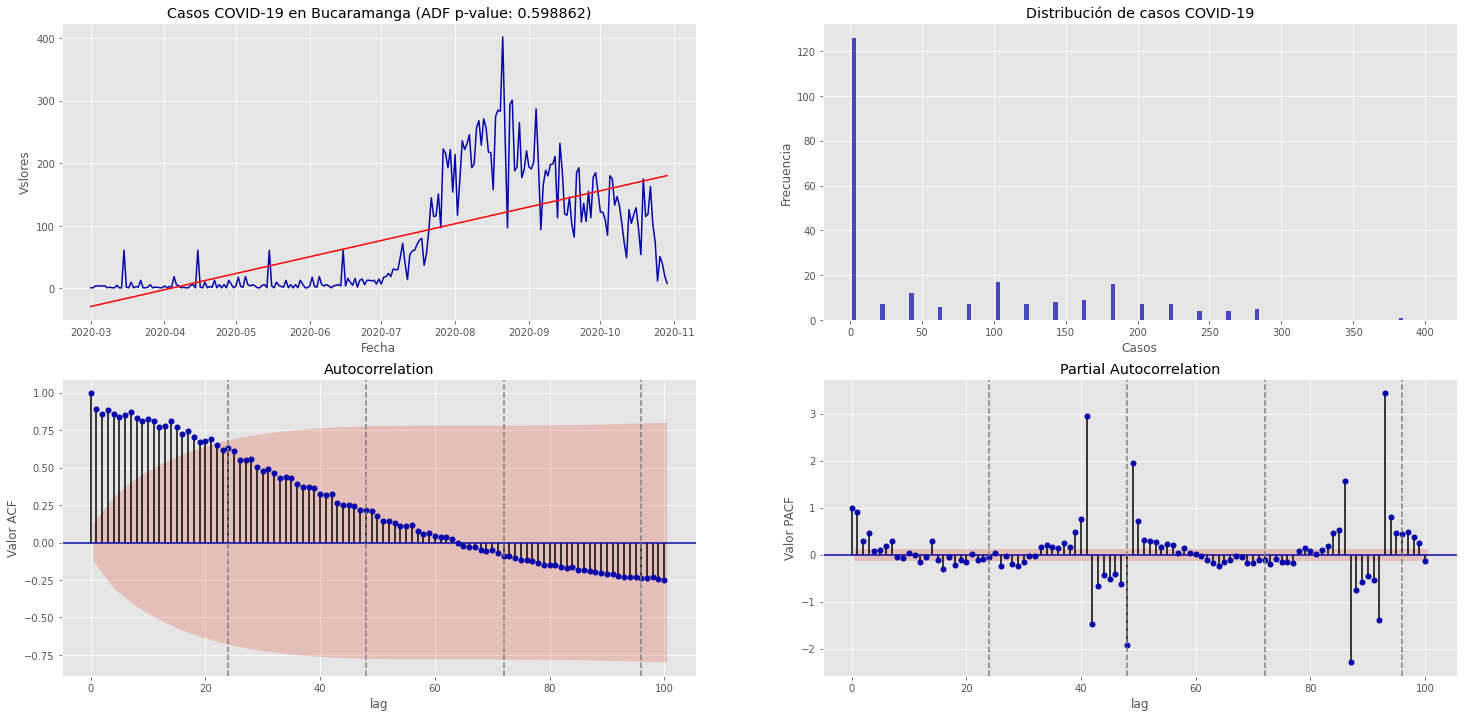

In [43]:
serie_bucaramanga = df_join.loc[(df_join.index>=initial_date)&(df_join.index<=final_date), 'BUCARAMANGA'].fillna(axis=0, method='backfill', inplace=False)
ts_analysis_plots(serie_bucaramanga)

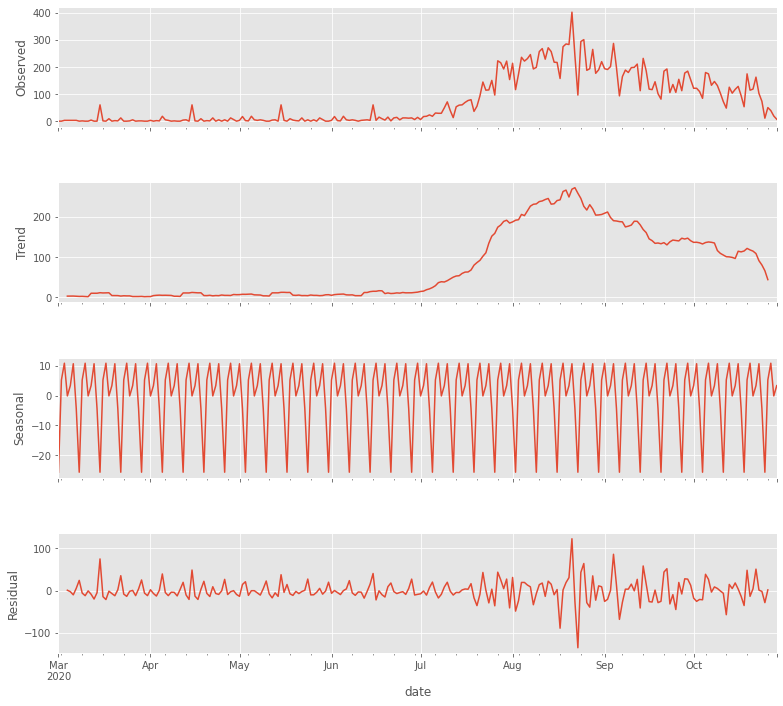

In [44]:
res = seasonal_decompose(serie_bucaramanga, model='additive')
fig = res.plot()
fig.set_size_inches((12, 12))

### Método de ensamblado (ML y DL) para la predicción de COVID-19 en Bucaramanga

In [ ]:
# Modelos
# ML
1. SVR -- DIRECTO
2. SVR -- RECURSIVO
3. XGBOOST -- DIRECTO
4. XGBOOST -- RECURSIVO
# DL
5. RNN -- DIRECTO 2 - BUCARAMANGA
6. RNN -- DIRECTO 2 - DEMAS SERIES
7. RNN -- AUTOREGRESIVO - BUCARAMANGA
8. RNN -- AUTOREGRESIVO - DEMÁS SERIES

# Modelos basados en DL

In [45]:
# Dataset con ventaneo
def windowed_dataset(series, 
                    past_window = 20, 
                    batch_size = 32, 
                    shuffle_buffer = 1000, 
                    future_window = 12,
                    col_test_series = 41):
    """
    Crea el dataset con ventaneo para realizar las predicciones de covid
    Parametros de entrada: past_window, batch_size, future_window, col_test_series 
    Retorna un dataset tf.data.dataset con la estructura definida
    """
    # Convertir la serie a tensor
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # La ventana será igual al numero de pasos del historico + los del futuro
    # Crea la ventana con una translación == shift=1. 
    # drop_remainder mantiene el numero de elementos en la ventana de las mismas dimensiones.
    # [[0, 1, 2, 3],
    #  [0, 1, 2, 3]]
    # [[1, 2, 3, 4],
    #  [1, 2, 3, 4]]
    # [[2, 3, 4, 5],
    #  [2, 3, 4, 5]]
    dataset = dataset.window(past_window+future_window, shift=1, drop_remainder=True)
    # Convertir a formato array
    dataset = dataset.flat_map(lambda window: window.batch(past_window+future_window))
    # Divide la ventana en pasado y futuro --> Es decir separa la ventana en features y target
    # Es posible predecir una o mas series para lo que se debe especificar que columna se desea predecir
    # [[0, 1, 2, 3],
    #  [0, 1, 2, 3]][4,5,6]
    # [[1, 2, 3, 4],
    #  [1, 2, 3, 4]][5,6,7]
    # [[2, 3, 4, 5],
    #  [2, 3, 4, 5]][6,7,8]
    dataset = dataset.map(lambda window: (window[:-future_window,:], window[-future_window:,col_test_series]))
    # Aplica cache y shuffle para hacer muestras independientes y evitar sesgos en las secuencia
    dataset = dataset.cache().shuffle(shuffle_buffer, reshuffle_each_iteration=True)
    # Genera los batch de datos y define el prefetch
    # x = [[[0, 1, 2, 3],
    #      [0, 1, 2, 3]], 
    #      [[4, 5, 6, 7],
    #       [4, 5, 6, 7]]
    # y = [[4,6,7], [8,9,10]]
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [46]:
def series_transformer(series_df, standarization, scaler):
    # inputar valores faltantes sobre la(s) serie(s)
    series_transformed = series_df.fillna(axis=0, method='backfill', inplace=False)
    # estandarizar la(s) serie(s) de tiempo
    scaler = None
    if standarization and scaler==None: # no hay entonces ajuste uno
        scaler = StandardScaler()
        scaler = scaler.fit(series_transformed.values)
        values = scaler.transform(series_transformed.values)
        series_transformed = pd.DataFrame(data=values, 
                                          columns=series_transformed.keys(), 
                                          index = series_transformed.index )
    elif standarization and scaler!=None: # estandarizar con uno existente (test)
        values = scaler.transform(series_transformed.values)
        series_transformed = pd.DataFrame(data=values, 
                                          columns=series_transformed.keys(), 
                                          index = series_transformed.index )    
    
    return series_transformed, scaler 

### Modelo 5 - RNN Directo sobre Bucaramanga

In [96]:
def build_standard_model(hp):
    """
    Crea y optimiza el modelo para la predicción directa de casos covid 
    Parametros de entrada: hp (objeto optimizador)
    Parametros globales: window_size, feature_dim, batch_size, stateful 
    Salida: Mejor modelo encontrado sobre el espacio de busqueda definido
    """
    # limpuar la gráfica y la sección
    tf.keras.backend.clear_session()
    gc.collect()
    # construir el modelo
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(window_size,feature_dim), batch_size=batch_size))
    # Shape [batch, time, series] => [batch, lstm_units]
    for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):
        model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i), [16, 32, 64, 128]), 
                                      return_sequences=True, stateful=stateful))
    model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i+1), [16, 32, 64, 128]), 
                                   return_sequences=False, stateful=stateful))
    # Shape [batch, lstm_units] => [batch, featuresDenseDim]
    model.add(tf.keras.layers.Dense(hp.Choice('units_' + str(i+2), [16, 32, 64, 128])))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(tf.keras.layers.Dense(future_steps))
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

In [48]:
# crear el objeto que va a ejecutar la optmización del modelo
tuner = kt.Hyperband(
    build_standard_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    project_name='model_5'
)

In [ ]:
# número de series a usar
feature_dim = 1
# indice de la columna a predecir
col_to_predict = 0 # Columna casos nuevos

In [75]:
# crear los datasets para entrenamiento y test según las fechas
final_data = df_join.loc[(df_join.index>=initial_date)&(df_join.index<=final_date)]
final_data_train = final_data.loc[final_data.index<=train_final_date]
final_data_test =  final_data.loc[final_data.index>train_final_date]

In [51]:
# Crear el dataset de entrenamiento
final_data_train, scaler  = series_transformer(final_data_train['BUCARAMANGA'].to_frame(), standarization=True, scaler=None)
dataset_train = windowed_dataset(final_data_train['BUCARAMANGA'].values.reshape(-1,1).astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=0)

In [52]:
# crear el dataset de test
# transformar la de test 
final_data_test, scaler = series_transformer(final_data_test['BUCARAMANGA'].to_frame(), standarization=True, scaler=scaler)
dataset_test = windowed_dataset(final_data_test['BUCARAMANGA'].values.reshape(-1,1).astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=0)

In [63]:
# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dataset_train,
             validation_data=dataset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])

Epoch 1/2
168/168 [==============================] - 21s 128ms/step - loss: 1.0740 - mean_absolute_error: 0.8638 - val_loss: 0.9249 - val_mean_absolute_error: 0.7328
Epoch 2/2
168/168 [==============================] - 21s 127ms/step - loss: 1.0738 - mean_absolute_error: 0.8639 - val_loss: 0.9250 - val_mean_absolute_error: 0.7328


Epoch 1/2
168/168 [==============================] - 16s 93ms/step - loss: 0.5641 - mean_absolute_error: 0.5568 - val_loss: 1.2133 - val_mean_absolute_error: 0.8864
Epoch 2/2
168/168 [==============================] - 15s 90ms/step - loss: 0.2147 - mean_absolute_error: 0.3105 - val_loss: 1.3139 - val_mean_absolute_error: 0.9212


Epoch 1/2
168/168 [==============================] - 29s 172ms/step - loss: 1.0967 - mean_absolute_error: 0.8740 - val_loss: 0.9315 - val_mean_absolute_error: 0.7372
Epoch 2/2
168/168 [==============================] - 28s 166ms/step - loss: 1.0918 - mean_absolute_error: 0.8725 - val_loss: 0.9317 - val_mean_absolute_error: 0.7372


Epoch 1/2
168/168 [==============================] - 22s 129ms/step - loss: 1.1209 - mean_absolute_error: 0.8689 - val_loss: 0.9577 - val_mean_absolute_error: 0.7491
Epoch 2/2
168/168 [==============================] - 21s 126ms/step - loss: 1.1118 - mean_absolute_error: 0.8658 - val_loss: 0.9577 - val_mean_absolute_error: 0.7491


Epoch 1/2
168/168 [==============================] - 15s 92ms/step - loss: 1.0814 - mean_absolute_error: 0.8671 - val_loss: 0.9344 - val_mean_absolute_error: 0.7399
Epoch 2/2
168/168 [==============================] - 15s 90ms/step - loss: 1.0797 - mean_absolute_error: 0.8664 - val_loss: 0.9345 - val_mean_absolute_error: 0.7399


Epoch 1/2
168/168 [==============================] - 22s 130ms/step - loss: 1.1023 - mean_absolute_error: 0.8714 - val_loss: 0.9447 - val_mean_absolute_error: 0.7412
Epoch 2/2
168/168 [==============================] - 22s 129ms/step - loss: 1.1061 - mean_absolute_error: 0.8736 - val_loss: 0.9447 - val_mean_absolute_error: 0.7412


Epoch 1/2
168/168 [==============================] - 16s 92ms/step - loss: 1.0666 - mean_absolute_error: 0.8577 - val_loss: 0.9363 - val_mean_absolute_error: 0.7374
Epoch 2/2
168/168 [==============================] - 16s 92ms/step - loss: 1.0681 - mean_absolute_error: 0.8581 - val_loss: 0.9363 - val_mean_absolute_error: 0.7374


Epoch 1/2
168/168 [==============================] - 16s 93ms/step - loss: 1.1193 - mean_absolute_error: 0.8829 - val_loss: 0.9433 - val_mean_absolute_error: 0.7418
Epoch 2/2
168/168 [==============================] - 15s 91ms/step - loss: 1.1090 - mean_absolute_error: 0.8788 - val_loss: 0.9433 - val_mean_absolute_error: 0.7418


Epoch 1/2
168/168 [==============================] - 22s 132ms/step - loss: 1.0425 - mean_absolute_error: 0.8449 - val_loss: 0.9294 - val_mean_absolute_error: 0.7336
Epoch 2/2
168/168 [==============================] - 21s 125ms/step - loss: 1.0407 - mean_absolute_error: 0.8437 - val_loss: 0.9298 - val_mean_absolute_error: 0.7336


Epoch 1/2
168/168 [==============================] - 22s 131ms/step - loss: 0.6866 - mean_absolute_error: 0.6423 - val_loss: 1.3830 - val_mean_absolute_error: 0.9554
Epoch 2/2
168/168 [==============================] - 21s 127ms/step - loss: 0.2872 - mean_absolute_error: 0.3746 - val_loss: 2.1422 - val_mean_absolute_error: 1.2326


Epoch 1/2
168/168 [==============================] - 28s 168ms/step - loss: 1.0816 - mean_absolute_error: 0.8664 - val_loss: 0.9375 - val_mean_absolute_error: 0.7373
Epoch 2/2
168/168 [==============================] - 28s 168ms/step - loss: 1.0722 - mean_absolute_error: 0.8626 - val_loss: 0.9386 - val_mean_absolute_error: 0.7373


Epoch 1/2
168/168 [==============================] - 15s 91ms/step - loss: 1.0695 - mean_absolute_error: 0.8609 - val_loss: 0.9304 - val_mean_absolute_error: 0.7344
Epoch 2/2
168/168 [==============================] - 15s 89ms/step - loss: 0.9786 - mean_absolute_error: 0.8216 - val_loss: 0.9341 - val_mean_absolute_error: 0.7371


Epoch 1/2
168/168 [==============================] - 28s 169ms/step - loss: 1.0686 - mean_absolute_error: 0.8623 - val_loss: 0.9336 - val_mean_absolute_error: 0.7377
Epoch 2/2
168/168 [==============================] - 28s 168ms/step - loss: 1.0706 - mean_absolute_error: 0.8624 - val_loss: 0.9336 - val_mean_absolute_error: 0.7377


Epoch 1/2
168/168 [==============================] - 22s 133ms/step - loss: 1.1020 - mean_absolute_error: 0.8617 - val_loss: 0.9233 - val_mean_absolute_error: 0.7317
Epoch 2/2
168/168 [==============================] - 21s 128ms/step - loss: 1.0490 - mean_absolute_error: 0.8391 - val_loss: 0.9298 - val_mean_absolute_error: 0.7345


Epoch 1/2
168/168 [==============================] - 22s 133ms/step - loss: 1.0883 - mean_absolute_error: 0.8702 - val_loss: 0.9308 - val_mean_absolute_error: 0.7353
Epoch 2/2
168/168 [==============================] - 22s 130ms/step - loss: 1.0878 - mean_absolute_error: 0.8705 - val_loss: 0.9309 - val_mean_absolute_error: 0.7353


Epoch 1/2
168/168 [==============================] - 15s 91ms/step - loss: 1.0742 - mean_absolute_error: 0.8613 - val_loss: 0.9244 - val_mean_absolute_error: 0.7357
Epoch 2/2
168/168 [==============================] - 15s 90ms/step - loss: 1.0416 - mean_absolute_error: 0.8464 - val_loss: 0.9285 - val_mean_absolute_error: 0.7382


Epoch 1/2
168/168 [==============================] - 22s 133ms/step - loss: 1.0146 - mean_absolute_error: 0.8354 - val_loss: 0.9406 - val_mean_absolute_error: 0.7413
Epoch 2/2
168/168 [==============================] - 22s 129ms/step - loss: 1.0090 - mean_absolute_error: 0.8338 - val_loss: 0.9408 - val_mean_absolute_error: 0.7413


Epoch 1/2
168/168 [==============================] - 22s 131ms/step - loss: 1.0700 - mean_absolute_error: 0.8613 - val_loss: 0.9336 - val_mean_absolute_error: 0.7371
Epoch 2/2
168/168 [==============================] - 22s 130ms/step - loss: 1.0692 - mean_absolute_error: 0.8614 - val_loss: 0.9336 - val_mean_absolute_error: 0.7371


Epoch 1/2
168/168 [==============================] - 15s 92ms/step - loss: 1.1834 - mean_absolute_error: 0.9088 - val_loss: 0.9378 - val_mean_absolute_error: 0.7387
Epoch 2/2
168/168 [==============================] - 15s 90ms/step - loss: 1.1715 - mean_absolute_error: 0.9043 - val_loss: 0.9373 - val_mean_absolute_error: 0.7385


Epoch 1/2
168/168 [==============================] - 29s 170ms/step - loss: 1.0876 - mean_absolute_error: 0.8719 - val_loss: 0.9397 - val_mean_absolute_error: 0.7386
Epoch 2/2
168/168 [==============================] - 28s 167ms/step - loss: 1.0804 - mean_absolute_error: 0.8694 - val_loss: 0.9446 - val_mean_absolute_error: 0.7398


Epoch 1/2
168/168 [==============================] - 16s 94ms/step - loss: 1.0066 - mean_absolute_error: 0.8283 - val_loss: 0.9301 - val_mean_absolute_error: 0.7391
Epoch 2/2
168/168 [==============================] - 15s 90ms/step - loss: 0.9050 - mean_absolute_error: 0.7827 - val_loss: 0.9418 - val_mean_absolute_error: 0.7451


Epoch 1/2
168/168 [==============================] - 22s 132ms/step - loss: 1.0784 - mean_absolute_error: 0.8663 - val_loss: 0.9307 - val_mean_absolute_error: 0.7361
Epoch 2/2
168/168 [==============================] - 22s 130ms/step - loss: 1.0768 - mean_absolute_error: 0.8663 - val_loss: 0.9307 - val_mean_absolute_error: 0.7361


Epoch 1/2
168/168 [==============================] - 15s 92ms/step - loss: 0.6588 - mean_absolute_error: 0.6184 - val_loss: 1.1766 - val_mean_absolute_error: 0.8728
Epoch 2/2
168/168 [==============================] - 15s 90ms/step - loss: 0.2072 - mean_absolute_error: 0.3057 - val_loss: 1.5177 - val_mean_absolute_error: 1.0009


Epoch 1/2
168/168 [==============================] - 22s 131ms/step - loss: 0.6685 - mean_absolute_error: 0.6277 - val_loss: 1.3757 - val_mean_absolute_error: 0.9470
Epoch 2/2
168/168 [==============================] - 22s 131ms/step - loss: 0.2677 - mean_absolute_error: 0.3604 - val_loss: 1.8608 - val_mean_absolute_error: 1.1369


Epoch 1/2
168/168 [==============================] - 22s 133ms/step - loss: 0.7548 - mean_absolute_error: 0.6920 - val_loss: 1.4620 - val_mean_absolute_error: 0.9823
Epoch 2/2
168/168 [==============================] - 22s 130ms/step - loss: 0.2076 - mean_absolute_error: 0.3089 - val_loss: 2.4304 - val_mean_absolute_error: 1.3275


Epoch 1/2
168/168 [==============================] - 29s 173ms/step - loss: 1.0820 - mean_absolute_error: 0.8697 - val_loss: 0.9414 - val_mean_absolute_error: 0.7377
Epoch 2/2
168/168 [==============================] - 28s 169ms/step - loss: 1.0493 - mean_absolute_error: 0.8585 - val_loss: 0.9516 - val_mean_absolute_error: 0.7395


Epoch 1/2
168/168 [==============================] - 23s 134ms/step - loss: 1.0814 - mean_absolute_error: 0.8671 - val_loss: 0.9360 - val_mean_absolute_error: 0.7397
Epoch 2/2
168/168 [==============================] - 22s 133ms/step - loss: 1.0783 - mean_absolute_error: 0.8651 - val_loss: 0.9364 - val_mean_absolute_error: 0.7397


Epoch 1/2
168/168 [==============================] - 29s 175ms/step - loss: 1.0964 - mean_absolute_error: 0.8742 - val_loss: 0.9357 - val_mean_absolute_error: 0.7394
Epoch 2/2
168/168 [==============================] - 29s 171ms/step - loss: 1.0967 - mean_absolute_error: 0.8746 - val_loss: 0.9358 - val_mean_absolute_error: 0.7394


Epoch 1/2
168/168 [==============================] - 16s 93ms/step - loss: 1.0304 - mean_absolute_error: 0.8441 - val_loss: 0.9458 - val_mean_absolute_error: 0.7409
Epoch 2/2
168/168 [==============================] - 15s 91ms/step - loss: 0.8934 - mean_absolute_error: 0.7803 - val_loss: 0.9560 - val_mean_absolute_error: 0.7484


Epoch 1/2
168/168 [==============================] - 22s 133ms/step - loss: 0.7078 - mean_absolute_error: 0.6593 - val_loss: 1.5408 - val_mean_absolute_error: 1.0209
Epoch 2/2
168/168 [==============================] - 22s 131ms/step - loss: 0.2478 - mean_absolute_error: 0.3450 - val_loss: 2.1400 - val_mean_absolute_error: 1.2355


Epoch 1/2
168/168 [==============================] - 15s 91ms/step - loss: 1.0754 - mean_absolute_error: 0.8571 - val_loss: 0.9278 - val_mean_absolute_error: 0.7353
Epoch 2/2
168/168 [==============================] - 15s 89ms/step - loss: 1.0646 - mean_absolute_error: 0.8545 - val_loss: 0.9281 - val_mean_absolute_error: 0.7354


Epoch 1/2
168/168 [==============================] - 22s 130ms/step - loss: 1.0525 - mean_absolute_error: 0.8531 - val_loss: 0.9272 - val_mean_absolute_error: 0.7331
Epoch 2/2
168/168 [==============================] - 21s 127ms/step - loss: 1.0533 - mean_absolute_error: 0.8537 - val_loss: 0.9272 - val_mean_absolute_error: 0.7331


Epoch 1/2
168/168 [==============================] - 22s 129ms/step - loss: 0.7118 - mean_absolute_error: 0.6570 - val_loss: 1.2467 - val_mean_absolute_error: 0.8880
Epoch 2/2
168/168 [==============================] - 21s 127ms/step - loss: 0.3710 - mean_absolute_error: 0.4255 - val_loss: 1.5757 - val_mean_absolute_error: 1.0333


Epoch 1/2
168/168 [==============================] - 22s 130ms/step - loss: 1.0889 - mean_absolute_error: 0.8719 - val_loss: 0.9425 - val_mean_absolute_error: 0.7404
Epoch 2/2
168/168 [==============================] - 21s 128ms/step - loss: 1.0518 - mean_absolute_error: 0.8563 - val_loss: 0.9505 - val_mean_absolute_error: 0.7433


Epoch 3/4
168/168 [==============================] - 22s 129ms/step - loss: 1.0643 - mean_absolute_error: 0.8584 - val_loss: 0.9440 - val_mean_absolute_error: 0.7424
Epoch 4/4
168/168 [==============================] - 21s 124ms/step - loss: 1.0387 - mean_absolute_error: 0.8437 - val_loss: 0.9491 - val_mean_absolute_error: 0.7446


Epoch 3/4
168/168 [==============================] - 21s 126ms/step - loss: 1.0859 - mean_absolute_error: 0.8677 - val_loss: 0.9307 - val_mean_absolute_error: 0.7343
Epoch 4/4
168/168 [==============================] - 21s 125ms/step - loss: 1.0844 - mean_absolute_error: 0.8675 - val_loss: 0.9308 - val_mean_absolute_error: 0.7343


Epoch 3/4
168/168 [==============================] - 21s 127ms/step - loss: 1.0644 - mean_absolute_error: 0.8600 - val_loss: 0.9346 - val_mean_absolute_error: 0.7379
Epoch 4/4
168/168 [==============================] - 21s 123ms/step - loss: 1.0670 - mean_absolute_error: 0.8613 - val_loss: 0.9346 - val_mean_absolute_error: 0.7379


Epoch 3/4
168/168 [==============================] - 21s 124ms/step - loss: 1.0893 - mean_absolute_error: 0.8709 - val_loss: 0.9317 - val_mean_absolute_error: 0.7368
Epoch 4/4
168/168 [==============================] - 21s 123ms/step - loss: 1.0841 - mean_absolute_error: 0.8689 - val_loss: 0.9322 - val_mean_absolute_error: 0.7367


Epoch 3/4
168/168 [==============================] - 15s 88ms/step - loss: 1.0531 - mean_absolute_error: 0.8558 - val_loss: 0.9309 - val_mean_absolute_error: 0.7356
Epoch 4/4
168/168 [==============================] - 14s 85ms/step - loss: 1.0085 - mean_absolute_error: 0.8364 - val_loss: 0.9319 - val_mean_absolute_error: 0.7350


Epoch 3/4
168/168 [==============================] - 14s 86ms/step - loss: 1.0258 - mean_absolute_error: 0.8385 - val_loss: 0.9292 - val_mean_absolute_error: 0.7349
Epoch 4/4
168/168 [==============================] - 14s 85ms/step - loss: 1.0222 - mean_absolute_error: 0.8363 - val_loss: 0.9294 - val_mean_absolute_error: 0.7349


Epoch 3/4
168/168 [==============================] - 21s 125ms/step - loss: 1.0854 - mean_absolute_error: 0.8688 - val_loss: 0.9356 - val_mean_absolute_error: 0.7374
Epoch 4/4
168/168 [==============================] - 21s 124ms/step - loss: 1.0826 - mean_absolute_error: 0.8675 - val_loss: 0.9357 - val_mean_absolute_error: 0.7374


Epoch 3/4
168/168 [==============================] - 15s 87ms/step - loss: 1.0264 - mean_absolute_error: 0.8414 - val_loss: 0.9362 - val_mean_absolute_error: 0.7388
Epoch 4/4
168/168 [==============================] - 14s 84ms/step - loss: 0.9890 - mean_absolute_error: 0.8246 - val_loss: 0.9425 - val_mean_absolute_error: 0.7419


Epoch 3/4
168/168 [==============================] - 20s 122ms/step - loss: 1.0758 - mean_absolute_error: 0.8654 - val_loss: 0.9348 - val_mean_absolute_error: 0.7383
Epoch 4/4
168/168 [==============================] - 20s 120ms/step - loss: 1.0779 - mean_absolute_error: 0.8661 - val_loss: 0.9348 - val_mean_absolute_error: 0.7383


Epoch 3/4
168/168 [==============================] - 20s 120ms/step - loss: 1.1119 - mean_absolute_error: 0.8802 - val_loss: 0.9285 - val_mean_absolute_error: 0.7340
Epoch 4/4
168/168 [==============================] - 20s 119ms/step - loss: 1.1082 - mean_absolute_error: 0.8792 - val_loss: 0.9285 - val_mean_absolute_error: 0.7340


Epoch 3/4
168/168 [==============================] - 27s 161ms/step - loss: 1.1182 - mean_absolute_error: 0.8837 - val_loss: 0.9296 - val_mean_absolute_error: 0.7362
Epoch 4/4
168/168 [==============================] - 26s 156ms/step - loss: 1.1189 - mean_absolute_error: 0.8843 - val_loss: 0.9298 - val_mean_absolute_error: 0.7362


Epoch 3/4
168/168 [==============================] - 27s 161ms/step - loss: 1.0832 - mean_absolute_error: 0.8681 - val_loss: 0.9274 - val_mean_absolute_error: 0.7346
Epoch 4/4
168/168 [==============================] - 26s 157ms/step - loss: 1.0790 - mean_absolute_error: 0.8665 - val_loss: 0.9294 - val_mean_absolute_error: 0.7352


Epoch 5/10
168/168 [==============================] - 20s 121ms/step - loss: 1.0772 - mean_absolute_error: 0.8660 - val_loss: 0.9322 - val_mean_absolute_error: 0.7366
Epoch 6/10
168/168 [==============================] - 20s 121ms/step - loss: 1.0774 - mean_absolute_error: 0.8663 - val_loss: 0.9322 - val_mean_absolute_error: 0.7366
Epoch 7/10
168/168 [==============================] - 20s 119ms/step - loss: 1.0783 - mean_absolute_error: 0.8666 - val_loss: 0.9322 - val_mean_absolute_error: 0.7366
Epoch 8/10
168/168 [==============================] - 20s 120ms/step - loss: 1.0789 - mean_absolute_error: 0.8666 - val_loss: 0.9322 - val_mean_absolute_error: 0.7366


Epoch 5/10
168/168 [==============================] - 20s 121ms/step - loss: 1.0242 - mean_absolute_error: 0.8390 - val_loss: 0.9338 - val_mean_absolute_error: 0.7358
Epoch 6/10
168/168 [==============================] - 20s 116ms/step - loss: 1.0241 - mean_absolute_error: 0.8385 - val_loss: 0.9339 - val_mean_absolute_error: 0.7359
Epoch 7/10
168/168 [==============================] - 20s 117ms/step - loss: 1.0278 - mean_absolute_error: 0.8391 - val_loss: 0.9340 - val_mean_absolute_error: 0.7359
Epoch 8/10
168/168 [==============================] - 20s 118ms/step - loss: 1.0247 - mean_absolute_error: 0.8382 - val_loss: 0.9340 - val_mean_absolute_error: 0.7359


Epoch 5/10
168/168 [==============================] - 26s 156ms/step - loss: 1.0829 - mean_absolute_error: 0.8685 - val_loss: 0.9379 - val_mean_absolute_error: 0.7396
Epoch 6/10
168/168 [==============================] - 26s 155ms/step - loss: 1.0821 - mean_absolute_error: 0.8679 - val_loss: 0.9388 - val_mean_absolute_error: 0.7398
Epoch 7/10
168/168 [==============================] - 27s 158ms/step - loss: 1.0778 - mean_absolute_error: 0.8665 - val_loss: 0.9397 - val_mean_absolute_error: 0.7400
Epoch 8/10
168/168 [==============================] - 27s 161ms/step - loss: 1.0748 - mean_absolute_error: 0.8653 - val_loss: 0.9408 - val_mean_absolute_error: 0.7403


Epoch 5/10
168/168 [==============================] - 15s 88ms/step - loss: 1.0528 - mean_absolute_error: 0.8460 - val_loss: 0.9136 - val_mean_absolute_error: 0.7276
Epoch 6/10
168/168 [==============================] - 15s 87ms/step - loss: 1.0380 - mean_absolute_error: 0.8417 - val_loss: 0.9146 - val_mean_absolute_error: 0.7280
Epoch 7/10
168/168 [==============================] - 15s 87ms/step - loss: 1.0382 - mean_absolute_error: 0.8404 - val_loss: 0.9157 - val_mean_absolute_error: 0.7284
Epoch 8/10
168/168 [==============================] - 15s 87ms/step - loss: 1.0442 - mean_absolute_error: 0.8396 - val_loss: 0.9167 - val_mean_absolute_error: 0.7287


Epoch 11/30
168/168 [==============================] - 15s 89ms/step - loss: 1.1093 - mean_absolute_error: 0.8763 - val_loss: 0.9231 - val_mean_absolute_error: 0.7323
Epoch 12/30
168/168 [==============================] - 15s 88ms/step - loss: 1.1018 - mean_absolute_error: 0.8722 - val_loss: 0.9232 - val_mean_absolute_error: 0.7324
Epoch 13/30
168/168 [==============================] - 15s 90ms/step - loss: 1.0978 - mean_absolute_error: 0.8709 - val_loss: 0.9235 - val_mean_absolute_error: 0.7325
Epoch 14/30
168/168 [==============================] - 15s 90ms/step - loss: 1.0902 - mean_absolute_error: 0.8677 - val_loss: 0.9240 - val_mean_absolute_error: 0.7327


Epoch 11/30
168/168 [==============================] - 22s 131ms/step - loss: 1.0449 - mean_absolute_error: 0.8476 - val_loss: 0.9336 - val_mean_absolute_error: 0.7390
Epoch 12/30
168/168 [==============================] - 22s 129ms/step - loss: 1.0441 - mean_absolute_error: 0.8474 - val_loss: 0.9338 - val_mean_absolute_error: 0.7391
Epoch 13/30
168/168 [==============================] - 22s 129ms/step - loss: 1.0373 - mean_absolute_error: 0.8448 - val_loss: 0.9340 - val_mean_absolute_error: 0.7391
Epoch 14/30
168/168 [==============================] - 22s 130ms/step - loss: 1.0362 - mean_absolute_error: 0.8432 - val_loss: 0.9342 - val_mean_absolute_error: 0.7392


Epoch 1/4
168/168 [==============================] - 16s 92ms/step - loss: 1.0358 - mean_absolute_error: 0.8449 - val_loss: 0.9384 - val_mean_absolute_error: 0.7385
Epoch 2/4
168/168 [==============================] - 15s 91ms/step - loss: 0.9405 - mean_absolute_error: 0.8024 - val_loss: 0.9448 - val_mean_absolute_error: 0.7407
Epoch 3/4
168/168 [==============================] - 15s 91ms/step - loss: 0.8347 - mean_absolute_error: 0.7521 - val_loss: 0.9521 - val_mean_absolute_error: 0.7465
Epoch 4/4
168/168 [==============================] - 16s 93ms/step - loss: 0.7283 - mean_absolute_error: 0.6912 - val_loss: 0.9663 - val_mean_absolute_error: 0.7573


Epoch 1/4
168/168 [==============================] - 22s 132ms/step - loss: 0.6744 - mean_absolute_error: 0.6379 - val_loss: 1.1002 - val_mean_absolute_error: 0.8287
Epoch 2/4
168/168 [==============================] - 22s 131ms/step - loss: 0.3547 - mean_absolute_error: 0.4284 - val_loss: 1.4195 - val_mean_absolute_error: 0.9587
Epoch 3/4
168/168 [==============================] - 22s 131ms/step - loss: 0.3217 - mean_absolute_error: 0.4035 - val_loss: 1.5421 - val_mean_absolute_error: 1.0141
Epoch 4/4
168/168 [==============================] - 22s 131ms/step - loss: 0.2887 - mean_absolute_error: 0.3771 - val_loss: 2.1734 - val_mean_absolute_error: 1.2336


Epoch 1/4
168/168 [==============================] - 29s 173ms/step - loss: 1.0728 - mean_absolute_error: 0.8644 - val_loss: 0.9431 - val_mean_absolute_error: 0.7412
Epoch 2/4
168/168 [==============================] - 29s 171ms/step - loss: 1.0528 - mean_absolute_error: 0.8567 - val_loss: 0.9493 - val_mean_absolute_error: 0.7432
Epoch 3/4
168/168 [==============================] - 29s 171ms/step - loss: 1.0266 - mean_absolute_error: 0.8458 - val_loss: 0.9569 - val_mean_absolute_error: 0.7458
Epoch 4/4
168/168 [==============================] - 28s 169ms/step - loss: 0.9991 - mean_absolute_error: 0.8310 - val_loss: 0.9697 - val_mean_absolute_error: 0.7507


Epoch 1/4
168/168 [==============================] - 16s 93ms/step - loss: 1.2952 - mean_absolute_error: 0.9458 - val_loss: 0.9554 - val_mean_absolute_error: 0.7378
Epoch 2/4
168/168 [==============================] - 15s 90ms/step - loss: 1.2957 - mean_absolute_error: 0.9491 - val_loss: 0.9554 - val_mean_absolute_error: 0.7378
Epoch 3/4
168/168 [==============================] - 15s 90ms/step - loss: 1.2984 - mean_absolute_error: 0.9468 - val_loss: 0.9554 - val_mean_absolute_error: 0.7378
Epoch 4/4
168/168 [==============================] - 15s 91ms/step - loss: 1.2899 - mean_absolute_error: 0.9448 - val_loss: 0.9554 - val_mean_absolute_error: 0.7378


Epoch 1/4
168/168 [==============================] - 28s 168ms/step - loss: 1.0675 - mean_absolute_error: 0.8620 - val_loss: 0.9322 - val_mean_absolute_error: 0.7373
Epoch 2/4
168/168 [==============================] - 27s 163ms/step - loss: 1.0555 - mean_absolute_error: 0.8567 - val_loss: 0.9339 - val_mean_absolute_error: 0.7376
Epoch 3/4
168/168 [==============================] - 27s 161ms/step - loss: 1.0465 - mean_absolute_error: 0.8526 - val_loss: 0.9355 - val_mean_absolute_error: 0.7378
Epoch 4/4
168/168 [==============================] - 27s 161ms/step - loss: 1.0326 - mean_absolute_error: 0.8469 - val_loss: 0.9378 - val_mean_absolute_error: 0.7383


Epoch 1/4
168/168 [==============================] - 15s 87ms/step - loss: 0.7438 - mean_absolute_error: 0.6742 - val_loss: 1.1691 - val_mean_absolute_error: 0.8599
Epoch 2/4
168/168 [==============================] - 15s 87ms/step - loss: 0.3817 - mean_absolute_error: 0.4374 - val_loss: 1.4015 - val_mean_absolute_error: 0.9560
Epoch 3/4
168/168 [==============================] - 15s 87ms/step - loss: 0.3194 - mean_absolute_error: 0.3982 - val_loss: 1.3167 - val_mean_absolute_error: 0.9249
Epoch 4/4
168/168 [==============================] - 14s 85ms/step - loss: 0.2777 - mean_absolute_error: 0.3682 - val_loss: 1.3483 - val_mean_absolute_error: 0.9386


Epoch 1/4
168/168 [==============================] - 27s 164ms/step - loss: 1.0250 - mean_absolute_error: 0.8390 - val_loss: 0.9334 - val_mean_absolute_error: 0.7381
Epoch 2/4
168/168 [==============================] - 26s 157ms/step - loss: 1.0246 - mean_absolute_error: 0.8389 - val_loss: 0.9336 - val_mean_absolute_error: 0.7382
Epoch 3/4
168/168 [==============================] - 26s 158ms/step - loss: 1.0242 - mean_absolute_error: 0.8388 - val_loss: 0.9337 - val_mean_absolute_error: 0.7382
Epoch 4/4
168/168 [==============================] - 26s 157ms/step - loss: 1.0239 - mean_absolute_error: 0.8386 - val_loss: 0.9339 - val_mean_absolute_error: 0.7383


Epoch 1/4
168/168 [==============================] - 14s 85ms/step - loss: 1.0167 - mean_absolute_error: 0.8344 - val_loss: 0.9363 - val_mean_absolute_error: 0.7406
Epoch 2/4
168/168 [==============================] - 14s 86ms/step - loss: 0.9260 - mean_absolute_error: 0.7942 - val_loss: 0.9440 - val_mean_absolute_error: 0.7444
Epoch 3/4
168/168 [==============================] - 14s 84ms/step - loss: 0.8528 - mean_absolute_error: 0.7552 - val_loss: 0.9506 - val_mean_absolute_error: 0.7485
Epoch 4/4
168/168 [==============================] - 14s 85ms/step - loss: 0.7600 - mean_absolute_error: 0.7050 - val_loss: 0.9604 - val_mean_absolute_error: 0.7553


Epoch 1/4
168/168 [==============================] - 21s 123ms/step - loss: 1.1026 - mean_absolute_error: 0.8739 - val_loss: 0.9367 - val_mean_absolute_error: 0.7387
Epoch 2/4
168/168 [==============================] - 20s 120ms/step - loss: 1.0943 - mean_absolute_error: 0.8710 - val_loss: 0.9367 - val_mean_absolute_error: 0.7387
Epoch 3/4
168/168 [==============================] - 20s 121ms/step - loss: 1.0980 - mean_absolute_error: 0.8724 - val_loss: 0.9367 - val_mean_absolute_error: 0.7387
Epoch 4/4
168/168 [==============================] - 20s 120ms/step - loss: 1.0921 - mean_absolute_error: 0.8714 - val_loss: 0.9367 - val_mean_absolute_error: 0.7387


Epoch 1/4
168/168 [==============================] - 21s 122ms/step - loss: 1.0402 - mean_absolute_error: 0.8475 - val_loss: 0.9432 - val_mean_absolute_error: 0.7429
Epoch 2/4
168/168 [==============================] - 20s 120ms/step - loss: 1.0342 - mean_absolute_error: 0.8438 - val_loss: 0.9436 - val_mean_absolute_error: 0.7432
Epoch 3/4
168/168 [==============================] - 20s 119ms/step - loss: 1.0282 - mean_absolute_error: 0.8404 - val_loss: 0.9442 - val_mean_absolute_error: 0.7436
Epoch 4/4
168/168 [==============================] - 20s 122ms/step - loss: 1.0092 - mean_absolute_error: 0.8345 - val_loss: 0.9459 - val_mean_absolute_error: 0.7442


Epoch 1/4
168/168 [==============================] - 14s 85ms/step - loss: 0.5144 - mean_absolute_error: 0.5289 - val_loss: 1.2691 - val_mean_absolute_error: 0.9108
Epoch 2/4
168/168 [==============================] - 14s 82ms/step - loss: 0.2161 - mean_absolute_error: 0.3103 - val_loss: 1.2875 - val_mean_absolute_error: 0.9144
Epoch 3/4
168/168 [==============================] - 14s 83ms/step - loss: 0.2072 - mean_absolute_error: 0.3038 - val_loss: 1.2830 - val_mean_absolute_error: 0.9154
Epoch 4/4
168/168 [==============================] - 14s 85ms/step - loss: 0.2097 - mean_absolute_error: 0.3063 - val_loss: 1.1930 - val_mean_absolute_error: 0.8801


Epoch 1/4
168/168 [==============================] - 26s 157ms/step - loss: 1.0732 - mean_absolute_error: 0.8638 - val_loss: 0.9326 - val_mean_absolute_error: 0.7360
Epoch 2/4
168/168 [==============================] - 26s 154ms/step - loss: 1.0734 - mean_absolute_error: 0.8637 - val_loss: 0.9327 - val_mean_absolute_error: 0.7360
Epoch 3/4
168/168 [==============================] - 26s 155ms/step - loss: 1.0732 - mean_absolute_error: 0.8640 - val_loss: 0.9328 - val_mean_absolute_error: 0.7360
Epoch 4/4
168/168 [==============================] - 26s 154ms/step - loss: 1.0730 - mean_absolute_error: 0.8636 - val_loss: 0.9328 - val_mean_absolute_error: 0.7360


Epoch 1/4
168/168 [==============================] - 26s 156ms/step - loss: 1.0560 - mean_absolute_error: 0.8554 - val_loss: 0.9382 - val_mean_absolute_error: 0.7388
Epoch 2/4
168/168 [==============================] - 26s 152ms/step - loss: 1.0553 - mean_absolute_error: 0.8549 - val_loss: 0.9383 - val_mean_absolute_error: 0.7389
Epoch 3/4
168/168 [==============================] - 26s 153ms/step - loss: 1.0539 - mean_absolute_error: 0.8543 - val_loss: 0.9385 - val_mean_absolute_error: 0.7389
Epoch 4/4
168/168 [==============================] - 26s 153ms/step - loss: 1.0554 - mean_absolute_error: 0.8550 - val_loss: 0.9386 - val_mean_absolute_error: 0.7389


Epoch 1/4
168/168 [==============================] - 14s 84ms/step - loss: 1.0286 - mean_absolute_error: 0.8394 - val_loss: 0.9265 - val_mean_absolute_error: 0.7366
Epoch 2/4
168/168 [==============================] - 14s 82ms/step - loss: 1.0203 - mean_absolute_error: 0.8355 - val_loss: 0.9274 - val_mean_absolute_error: 0.7369
Epoch 3/4
168/168 [==============================] - 14s 81ms/step - loss: 1.0100 - mean_absolute_error: 0.8309 - val_loss: 0.9284 - val_mean_absolute_error: 0.7371
Epoch 4/4
168/168 [==============================] - 14s 81ms/step - loss: 0.9989 - mean_absolute_error: 0.8269 - val_loss: 0.9293 - val_mean_absolute_error: 0.7373


Epoch 1/4
168/168 [==============================] - 26s 155ms/step - loss: 0.6199 - mean_absolute_error: 0.5983 - val_loss: 2.1540 - val_mean_absolute_error: 1.2378
Epoch 2/4
168/168 [==============================] - 26s 153ms/step - loss: 0.2355 - mean_absolute_error: 0.3320 - val_loss: 2.5781 - val_mean_absolute_error: 1.3874
Epoch 3/4
168/168 [==============================] - 26s 154ms/step - loss: 0.2075 - mean_absolute_error: 0.3068 - val_loss: 2.5059 - val_mean_absolute_error: 1.3611
Epoch 4/4
168/168 [==============================] - 26s 153ms/step - loss: 0.2042 - mean_absolute_error: 0.3067 - val_loss: 3.1504 - val_mean_absolute_error: 1.5431


Epoch 5/10
168/168 [==============================] - 26s 157ms/step - loss: 1.0845 - mean_absolute_error: 0.8672 - val_loss: 0.9346 - val_mean_absolute_error: 0.7380
Epoch 6/10
168/168 [==============================] - 26s 153ms/step - loss: 1.0859 - mean_absolute_error: 0.8680 - val_loss: 0.9347 - val_mean_absolute_error: 0.7380
Epoch 7/10
168/168 [==============================] - 26s 152ms/step - loss: 1.0833 - mean_absolute_error: 0.8669 - val_loss: 0.9348 - val_mean_absolute_error: 0.7381
Epoch 8/10
168/168 [==============================] - 25s 151ms/step - loss: 1.0831 - mean_absolute_error: 0.8668 - val_loss: 0.9349 - val_mean_absolute_error: 0.7381


Epoch 5/10
168/168 [==============================] - 14s 84ms/step - loss: 1.1805 - mean_absolute_error: 0.9067 - val_loss: 0.9328 - val_mean_absolute_error: 0.7334
Epoch 6/10
168/168 [==============================] - 14s 81ms/step - loss: 1.1588 - mean_absolute_error: 0.8990 - val_loss: 0.9330 - val_mean_absolute_error: 0.7335
Epoch 7/10
168/168 [==============================] - 14s 81ms/step - loss: 1.1519 - mean_absolute_error: 0.8946 - val_loss: 0.9332 - val_mean_absolute_error: 0.7336
Epoch 8/10
168/168 [==============================] - 14s 83ms/step - loss: 1.1438 - mean_absolute_error: 0.8911 - val_loss: 0.9337 - val_mean_absolute_error: 0.7338


Epoch 5/10
168/168 [==============================] - 26s 155ms/step - loss: 1.0655 - mean_absolute_error: 0.8590 - val_loss: 0.9384 - val_mean_absolute_error: 0.7397
Epoch 6/10
168/168 [==============================] - 26s 152ms/step - loss: 1.0609 - mean_absolute_error: 0.8573 - val_loss: 0.9396 - val_mean_absolute_error: 0.7397
Epoch 7/10
168/168 [==============================] - 25s 150ms/step - loss: 1.0514 - mean_absolute_error: 0.8528 - val_loss: 0.9408 - val_mean_absolute_error: 0.7398
Epoch 8/10
168/168 [==============================] - 26s 152ms/step - loss: 1.0406 - mean_absolute_error: 0.8487 - val_loss: 0.9420 - val_mean_absolute_error: 0.7398


Epoch 5/10
168/168 [==============================] - 14s 84ms/step - loss: 1.0466 - mean_absolute_error: 0.8467 - val_loss: 0.9253 - val_mean_absolute_error: 0.7334
Epoch 6/10
168/168 [==============================] - 14s 82ms/step - loss: 1.0505 - mean_absolute_error: 0.8483 - val_loss: 0.9253 - val_mean_absolute_error: 0.7334
Epoch 7/10
168/168 [==============================] - 14s 82ms/step - loss: 1.0417 - mean_absolute_error: 0.8453 - val_loss: 0.9253 - val_mean_absolute_error: 0.7334
Epoch 8/10
168/168 [==============================] - 14s 81ms/step - loss: 1.0436 - mean_absolute_error: 0.8461 - val_loss: 0.9253 - val_mean_absolute_error: 0.7334


Epoch 5/10
168/168 [==============================] - 26s 155ms/step - loss: 1.0830 - mean_absolute_error: 0.8688 - val_loss: 0.9324 - val_mean_absolute_error: 0.7383
Epoch 6/10
168/168 [==============================] - 26s 153ms/step - loss: 1.0828 - mean_absolute_error: 0.8687 - val_loss: 0.9324 - val_mean_absolute_error: 0.7383
Epoch 7/10
168/168 [==============================] - 26s 154ms/step - loss: 1.0825 - mean_absolute_error: 0.8686 - val_loss: 0.9325 - val_mean_absolute_error: 0.7383
Epoch 8/10
168/168 [==============================] - 26s 154ms/step - loss: 1.0823 - mean_absolute_error: 0.8685 - val_loss: 0.9325 - val_mean_absolute_error: 0.7383


Epoch 11/30
168/168 [==============================] - 14s 84ms/step - loss: 1.2264 - mean_absolute_error: 0.9227 - val_loss: 0.9374 - val_mean_absolute_error: 0.7382
Epoch 12/30
168/168 [==============================] - 14s 84ms/step - loss: 1.2165 - mean_absolute_error: 0.9222 - val_loss: 0.9374 - val_mean_absolute_error: 0.7382
Epoch 13/30
168/168 [==============================] - 15s 87ms/step - loss: 1.2248 - mean_absolute_error: 0.9231 - val_loss: 0.9374 - val_mean_absolute_error: 0.7382
Epoch 14/30
168/168 [==============================] - 15s 87ms/step - loss: 1.2106 - mean_absolute_error: 0.9167 - val_loss: 0.9374 - val_mean_absolute_error: 0.7382
Epoch 15/30
168/168 [==============================] - 15s 87ms/step - loss: 1.2181 - mean_absolute_error: 0.9206 - val_loss: 0.9374 - val_mean_absolute_error: 0.7382
Epoch 16/30
168/168 [==============================] - 15s 88ms/step - loss: 1.2153 - mean_absolute_error: 0.9198 - val_loss: 0.9374 - val_mean_absolute_error: 0.738

Epoch 11/30
168/168 [==============================] - 14s 84ms/step - loss: 1.0813 - mean_absolute_error: 0.8541 - val_loss: 0.9249 - val_mean_absolute_error: 0.7421
Epoch 12/30
168/168 [==============================] - 14s 84ms/step - loss: 1.0762 - mean_absolute_error: 0.8526 - val_loss: 0.9260 - val_mean_absolute_error: 0.7425
Epoch 13/30
168/168 [==============================] - 14s 85ms/step - loss: 1.0679 - mean_absolute_error: 0.8490 - val_loss: 0.9272 - val_mean_absolute_error: 0.7430
Epoch 14/30
168/168 [==============================] - 14s 85ms/step - loss: 1.0627 - mean_absolute_error: 0.8480 - val_loss: 0.9283 - val_mean_absolute_error: 0.7434


Epoch 1/10
168/168 [==============================] - 21s 127ms/step - loss: 1.0556 - mean_absolute_error: 0.8543 - val_loss: 0.9480 - val_mean_absolute_error: 0.7395
Epoch 2/10
168/168 [==============================] - 21s 125ms/step - loss: 0.8523 - mean_absolute_error: 0.7650 - val_loss: 0.9797 - val_mean_absolute_error: 0.7539
Epoch 3/10
168/168 [==============================] - 21s 125ms/step - loss: 0.6408 - mean_absolute_error: 0.6457 - val_loss: 1.0378 - val_mean_absolute_error: 0.7887
Epoch 4/10
168/168 [==============================] - 20s 121ms/step - loss: 0.4528 - mean_absolute_error: 0.5148 - val_loss: 1.1324 - val_mean_absolute_error: 0.8465


Epoch 1/10
168/168 [==============================] - 14s 85ms/step - loss: 0.6696 - mean_absolute_error: 0.6388 - val_loss: 1.2218 - val_mean_absolute_error: 0.8885
Epoch 2/10
168/168 [==============================] - 14s 84ms/step - loss: 0.2358 - mean_absolute_error: 0.3350 - val_loss: 1.6023 - val_mean_absolute_error: 1.0292
Epoch 3/10
168/168 [==============================] - 14s 83ms/step - loss: 0.2345 - mean_absolute_error: 0.3305 - val_loss: 1.3160 - val_mean_absolute_error: 0.9266
Epoch 4/10
168/168 [==============================] - 14s 82ms/step - loss: 0.2220 - mean_absolute_error: 0.3178 - val_loss: 1.5421 - val_mean_absolute_error: 1.0085


Epoch 1/10
168/168 [==============================] - 20s 118ms/step - loss: 1.1117 - mean_absolute_error: 0.8788 - val_loss: 0.9347 - val_mean_absolute_error: 0.7386
Epoch 2/10
168/168 [==============================] - 20s 116ms/step - loss: 1.1082 - mean_absolute_error: 0.8767 - val_loss: 0.9357 - val_mean_absolute_error: 0.7388
Epoch 3/10
168/168 [==============================] - 20s 117ms/step - loss: 1.1074 - mean_absolute_error: 0.8768 - val_loss: 0.9361 - val_mean_absolute_error: 0.7388
Epoch 4/10
168/168 [==============================] - 19s 115ms/step - loss: 1.1018 - mean_absolute_error: 0.8756 - val_loss: 0.9365 - val_mean_absolute_error: 0.7389


Epoch 1/10
168/168 [==============================] - 26s 152ms/step - loss: 1.0828 - mean_absolute_error: 0.8678 - val_loss: 0.9309 - val_mean_absolute_error: 0.7362
Epoch 2/10
168/168 [==============================] - 25s 148ms/step - loss: 1.0849 - mean_absolute_error: 0.8686 - val_loss: 0.9310 - val_mean_absolute_error: 0.7362
Epoch 3/10
168/168 [==============================] - 25s 151ms/step - loss: 1.0829 - mean_absolute_error: 0.8675 - val_loss: 0.9311 - val_mean_absolute_error: 0.7362
Epoch 4/10
168/168 [==============================] - 25s 150ms/step - loss: 1.0838 - mean_absolute_error: 0.8675 - val_loss: 0.9312 - val_mean_absolute_error: 0.7362


Epoch 1/10
168/168 [==============================] - 20s 117ms/step - loss: 1.0726 - mean_absolute_error: 0.8629 - val_loss: 0.9456 - val_mean_absolute_error: 0.7392
Epoch 2/10
168/168 [==============================] - 19s 115ms/step - loss: 0.9911 - mean_absolute_error: 0.8266 - val_loss: 0.9556 - val_mean_absolute_error: 0.7425
Epoch 3/10
168/168 [==============================] - 19s 116ms/step - loss: 0.8864 - mean_absolute_error: 0.7802 - val_loss: 0.9752 - val_mean_absolute_error: 0.7508
Epoch 4/10
168/168 [==============================] - 20s 116ms/step - loss: 0.7781 - mean_absolute_error: 0.7210 - val_loss: 0.9993 - val_mean_absolute_error: 0.7631


Epoch 1/10
168/168 [==============================] - 26s 154ms/step - loss: 1.0839 - mean_absolute_error: 0.8691 - val_loss: 0.9281 - val_mean_absolute_error: 0.7351
Epoch 2/10
168/168 [==============================] - 25s 151ms/step - loss: 1.0845 - mean_absolute_error: 0.8691 - val_loss: 0.9281 - val_mean_absolute_error: 0.7351
Epoch 3/10
168/168 [==============================] - 25s 150ms/step - loss: 1.0814 - mean_absolute_error: 0.8684 - val_loss: 0.9281 - val_mean_absolute_error: 0.7351
Epoch 4/10
168/168 [==============================] - 25s 150ms/step - loss: 1.0829 - mean_absolute_error: 0.8686 - val_loss: 0.9282 - val_mean_absolute_error: 0.7351


Epoch 1/10
168/168 [==============================] - 20s 119ms/step - loss: 1.0007 - mean_absolute_error: 0.8290 - val_loss: 0.9469 - val_mean_absolute_error: 0.7450
Epoch 2/10
168/168 [==============================] - 20s 117ms/step - loss: 0.9243 - mean_absolute_error: 0.7935 - val_loss: 0.9602 - val_mean_absolute_error: 0.7492
Epoch 3/10
168/168 [==============================] - 20s 117ms/step - loss: 0.8465 - mean_absolute_error: 0.7536 - val_loss: 0.9787 - val_mean_absolute_error: 0.7597
Epoch 4/10
168/168 [==============================] - 20s 116ms/step - loss: 0.7476 - mean_absolute_error: 0.6995 - val_loss: 1.0058 - val_mean_absolute_error: 0.7770


Epoch 1/10
168/168 [==============================] - 20s 120ms/step - loss: 0.5856 - mean_absolute_error: 0.5771 - val_loss: 1.5956 - val_mean_absolute_error: 1.0435
Epoch 2/10
168/168 [==============================] - 19s 116ms/step - loss: 0.2374 - mean_absolute_error: 0.3306 - val_loss: 1.7161 - val_mean_absolute_error: 1.0864
Epoch 3/10
168/168 [==============================] - 20s 116ms/step - loss: 0.2259 - mean_absolute_error: 0.3223 - val_loss: 1.7231 - val_mean_absolute_error: 1.0841
Epoch 4/10
168/168 [==============================] - 19s 114ms/step - loss: 0.1911 - mean_absolute_error: 0.2968 - val_loss: 2.1647 - val_mean_absolute_error: 1.2422


Epoch 11/30
168/168 [==============================] - 26s 154ms/step - loss: 1.0713 - mean_absolute_error: 0.8635 - val_loss: 0.9353 - val_mean_absolute_error: 0.7389
Epoch 12/30
168/168 [==============================] - 25s 150ms/step - loss: 1.0722 - mean_absolute_error: 0.8633 - val_loss: 0.9353 - val_mean_absolute_error: 0.7389
Epoch 13/30
168/168 [==============================] - 25s 151ms/step - loss: 1.0710 - mean_absolute_error: 0.8631 - val_loss: 0.9353 - val_mean_absolute_error: 0.7389
Epoch 14/30
168/168 [==============================] - 25s 150ms/step - loss: 1.0717 - mean_absolute_error: 0.8631 - val_loss: 0.9353 - val_mean_absolute_error: 0.7389


Epoch 11/30
168/168 [==============================] - 26s 153ms/step - loss: 1.0902 - mean_absolute_error: 0.8698 - val_loss: 0.9305 - val_mean_absolute_error: 0.7341
Epoch 12/30
168/168 [==============================] - 25s 148ms/step - loss: 1.0869 - mean_absolute_error: 0.8689 - val_loss: 0.9306 - val_mean_absolute_error: 0.7341
Epoch 13/30
168/168 [==============================] - 25s 150ms/step - loss: 1.0867 - mean_absolute_error: 0.8684 - val_loss: 0.9307 - val_mean_absolute_error: 0.7341
Epoch 14/30
168/168 [==============================] - 26s 152ms/step - loss: 1.0831 - mean_absolute_error: 0.8670 - val_loss: 0.9307 - val_mean_absolute_error: 0.7341


Epoch 11/30
168/168 [==============================] - 20s 119ms/step - loss: 1.0715 - mean_absolute_error: 0.8630 - val_loss: 0.9387 - val_mean_absolute_error: 0.7380
Epoch 12/30
168/168 [==============================] - 20s 118ms/step - loss: 1.0622 - mean_absolute_error: 0.8591 - val_loss: 0.9393 - val_mean_absolute_error: 0.7381
Epoch 13/30
168/168 [==============================] - 20s 118ms/step - loss: 1.0642 - mean_absolute_error: 0.8596 - val_loss: 0.9400 - val_mean_absolute_error: 0.7382
Epoch 14/30
168/168 [==============================] - 20s 117ms/step - loss: 1.0605 - mean_absolute_error: 0.8580 - val_loss: 0.9406 - val_mean_absolute_error: 0.7383


Epoch 1/30
168/168 [==============================] - 26s 155ms/step - loss: 0.7657 - mean_absolute_error: 0.6916 - val_loss: 1.3327 - val_mean_absolute_error: 0.9412
Epoch 2/30
168/168 [==============================] - 26s 154ms/step - loss: 0.4491 - mean_absolute_error: 0.4844 - val_loss: 1.6505 - val_mean_absolute_error: 1.0490
Epoch 3/30
168/168 [==============================] - 26s 155ms/step - loss: 0.3757 - mean_absolute_error: 0.4321 - val_loss: 2.8245 - val_mean_absolute_error: 1.4469
Epoch 4/30
168/168 [==============================] - 26s 153ms/step - loss: 0.3389 - mean_absolute_error: 0.4141 - val_loss: 2.3846 - val_mean_absolute_error: 1.3096


Epoch 1/30
168/168 [==============================] - 26s 155ms/step - loss: 1.0783 - mean_absolute_error: 0.8669 - val_loss: 0.9342 - val_mean_absolute_error: 0.7375
Epoch 2/30
168/168 [==============================] - 26s 153ms/step - loss: 1.0782 - mean_absolute_error: 0.8668 - val_loss: 0.9350 - val_mean_absolute_error: 0.7377
Epoch 3/30
168/168 [==============================] - 26s 153ms/step - loss: 1.0749 - mean_absolute_error: 0.8660 - val_loss: 0.9359 - val_mean_absolute_error: 0.7379
Epoch 4/30
168/168 [==============================] - 26s 156ms/step - loss: 1.0736 - mean_absolute_error: 0.8654 - val_loss: 0.9367 - val_mean_absolute_error: 0.7380


Epoch 1/30
168/168 [==============================] - 20s 121ms/step - loss: 1.1240 - mean_absolute_error: 0.8862 - val_loss: 0.9312 - val_mean_absolute_error: 0.7360
Epoch 2/30
168/168 [==============================] - 20s 122ms/step - loss: 1.1152 - mean_absolute_error: 0.8824 - val_loss: 0.9319 - val_mean_absolute_error: 0.7360
Epoch 3/30
168/168 [==============================] - 21s 122ms/step - loss: 1.1066 - mean_absolute_error: 0.8796 - val_loss: 0.9326 - val_mean_absolute_error: 0.7361
Epoch 4/30
168/168 [==============================] - 20s 122ms/step - loss: 1.0980 - mean_absolute_error: 0.8758 - val_loss: 0.9333 - val_mean_absolute_error: 0.7363


Epoch 1/30
168/168 [==============================] - 27s 162ms/step - loss: 0.6011 - mean_absolute_error: 0.5814 - val_loss: 2.4715 - val_mean_absolute_error: 1.3498
Epoch 2/30
168/168 [==============================] - 27s 159ms/step - loss: 0.1683 - mean_absolute_error: 0.2653 - val_loss: 3.3280 - val_mean_absolute_error: 1.6047
Epoch 3/30
168/168 [==============================] - 27s 159ms/step - loss: 0.1511 - mean_absolute_error: 0.2494 - val_loss: 3.3676 - val_mean_absolute_error: 1.6104
Epoch 4/30
168/168 [==============================] - 26s 155ms/step - loss: 0.1442 - mean_absolute_error: 0.2416 - val_loss: 3.5987 - val_mean_absolute_error: 1.6687


Epoch 1/30
168/168 [==============================] - 14s 86ms/step - loss: 0.5775 - mean_absolute_error: 0.5789 - val_loss: 1.1521 - val_mean_absolute_error: 0.8603
Epoch 2/30
168/168 [==============================] - 14s 85ms/step - loss: 0.3174 - mean_absolute_error: 0.3889 - val_loss: 1.2740 - val_mean_absolute_error: 0.9116
Epoch 3/30
168/168 [==============================] - 14s 86ms/step - loss: 0.2888 - mean_absolute_error: 0.3757 - val_loss: 1.3067 - val_mean_absolute_error: 0.9204
Epoch 4/30
168/168 [==============================] - 14s 85ms/step - loss: 0.2521 - mean_absolute_error: 0.3449 - val_loss: 1.3011 - val_mean_absolute_error: 0.9208


INFO:tensorflow:Oracle triggered exit


In [64]:
best_model_5 = tuner.get_best_models(1)[0]

In [65]:
best_hyperparameters_5 = tuner.get_best_hyperparameters(1)[0]

In [67]:
vars(best_hyperparameters_5)

{'_scopes': [],
 '_space': {'clipvalue': Choice(name: "clipvalue", values: [1.0, 2.0, 5.0, 10.0], ordered: True, default: 1.0),
  'dropout': Float(name: "dropout", min_value: 0.0, max_value: 0.5, step: 0.1, sampling: None, default: 0.5),
  'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001, 1e-05, 1e-06], ordered: True, default: 0.01),
  'num_layers': Int(name: "num_layers", min_value: 1, max_value: 3, step: 1, sampling: None, default: 1),
  'units_0': Choice(name: "units_0", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_1': Choice(name: "units_1", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_2': Choice(name: "units_2", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_3': Choice(name: "units_3", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_4': Choice(name: "units_4", values: [16, 32, 64, 128], ordered: True, default: 16)},
 'values': {'clipvalue': 10.0,
  'dropout': 0.5,
  'learning_rate

In [68]:
best_model_5.evaluate(dataset_test)

7/7 [==============================] - 0s 9ms/step - loss: 0.9136 - mean_absolute_error: 0.7276


[0.9135825037956238, 0.7276081442832947]

In [ ]:
predictions = best_model_5.predict(dataset_test)

In [78]:
# Guardar el mejor modelo y scaler
best_model_5.save('model_5/best_model_5.h5')
# save the scaler
pkl.dump(scaler, open('model_5/scaler_model_5.pkl', 'wb'))

### Modelo 6 RNN directo sobre todas las series

In [83]:
# crear los datasets para entrenamiento y test según las fechas
selected = contries_top + departamentos_iniciales + ciudades_iniciales 
final_data = df_join.loc[(df_join.index>=initial_date)&(df_join.index<=final_date), selected]
final_data_train_df = final_data.loc[final_data.index<=train_final_date]
final_data_test_df =  final_data.loc[final_data.index>train_final_date]

In [90]:
# número de series a usar
feature_dim = len(selected)
# indice de la columna a predecir
col_to_predict = final_data_train_df.keys().tolist().index('BUCARAMANGA') # Columna casos nuevos

In [94]:
# Crear el dataset de entrenamiento
final_data_train, scaler  = series_transformer(final_data_train_df, standarization=True, scaler=None)
dataset_train = windowed_dataset(final_data_train.values.astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=col_to_predict)

In [97]:
# crear el dataset de test
# transformar la de test 
final_data_test, scaler = series_transformer(final_data_test_df, standarization=True, scaler=scaler)
dataset_test = windowed_dataset(final_data_test.values.astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=col_to_predict)

In [98]:
# crear el objeto que va a ejecutar la optmización del modelo
tuner = kt.Hyperband(
    build_standard_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    project_name='model_6'
)

In [99]:
# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dataset_train,
             validation_data=dataset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])

Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.8943 - mean_absolute_error: 0.7765 - val_loss: 0.9115 - val_mean_absolute_error: 0.7303
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.8884 - mean_absolute_error: 0.7721 - val_loss: 0.9116 - val_mean_absolute_error: 0.7304


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 0.1794 - mean_absolute_error: 0.2814 - val_loss: 0.9212 - val_mean_absolute_error: 0.7492
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.0576 - mean_absolute_error: 0.1712 - val_loss: 0.9362 - val_mean_absolute_error: 0.7527


Epoch 1/2
168/168 [==============================] - 3s 16ms/step - loss: 1.0249 - mean_absolute_error: 0.8201 - val_loss: 0.9487 - val_mean_absolute_error: 0.7484
Epoch 2/2
168/168 [==============================] - 2s 9ms/step - loss: 1.0031 - mean_absolute_error: 0.8174 - val_loss: 0.9496 - val_mean_absolute_error: 0.7488


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.9191 - mean_absolute_error: 0.8045 - val_loss: 0.9619 - val_mean_absolute_error: 0.7543
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.9062 - mean_absolute_error: 0.7970 - val_loss: 0.9619 - val_mean_absolute_error: 0.7543


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 1.0723 - mean_absolute_error: 0.8456 - val_loss: 0.9491 - val_mean_absolute_error: 0.7466
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0588 - mean_absolute_error: 0.8403 - val_loss: 0.9481 - val_mean_absolute_error: 0.7462


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 1.0033 - mean_absolute_error: 0.8051 - val_loss: 0.9988 - val_mean_absolute_error: 0.7691
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.9878 - mean_absolute_error: 0.8066 - val_loss: 0.9989 - val_mean_absolute_error: 0.7691


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 1.0202 - mean_absolute_error: 0.8307 - val_loss: 0.9947 - val_mean_absolute_error: 0.7717
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0073 - mean_absolute_error: 0.8247 - val_loss: 0.9947 - val_mean_absolute_error: 0.7717


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 0.9434 - mean_absolute_error: 0.7968 - val_loss: 0.9279 - val_mean_absolute_error: 0.7351
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.9243 - mean_absolute_error: 0.7876 - val_loss: 0.9274 - val_mean_absolute_error: 0.7345


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.8617 - mean_absolute_error: 0.7391 - val_loss: 0.9080 - val_mean_absolute_error: 0.7398
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.7552 - mean_absolute_error: 0.6812 - val_loss: 0.9088 - val_mean_absolute_error: 0.7401


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.5088 - mean_absolute_error: 0.5217 - val_loss: 0.8686 - val_mean_absolute_error: 0.7239
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.1775 - mean_absolute_error: 0.2899 - val_loss: 0.8939 - val_mean_absolute_error: 0.7304


Epoch 1/2
168/168 [==============================] - 3s 16ms/step - loss: 0.9216 - mean_absolute_error: 0.8051 - val_loss: 0.9656 - val_mean_absolute_error: 0.7599
Epoch 2/2
168/168 [==============================] - 2s 9ms/step - loss: 0.8968 - mean_absolute_error: 0.7913 - val_loss: 0.9653 - val_mean_absolute_error: 0.7597


Epoch 1/2
168/168 [==============================] - 2s 10ms/step - loss: 0.8769 - mean_absolute_error: 0.7388 - val_loss: 0.9354 - val_mean_absolute_error: 0.7430
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.5841 - mean_absolute_error: 0.5775 - val_loss: 0.9324 - val_mean_absolute_error: 0.7459


Epoch 1/2
168/168 [==============================] - 3s 16ms/step - loss: 0.8706 - mean_absolute_error: 0.7827 - val_loss: 0.9487 - val_mean_absolute_error: 0.7402
Epoch 2/2
168/168 [==============================] - 2s 9ms/step - loss: 0.8709 - mean_absolute_error: 0.7825 - val_loss: 0.9487 - val_mean_absolute_error: 0.7402


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.8499 - mean_absolute_error: 0.7536 - val_loss: 0.9857 - val_mean_absolute_error: 0.7752
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.7615 - mean_absolute_error: 0.6935 - val_loss: 0.9749 - val_mean_absolute_error: 0.7717


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.8074 - mean_absolute_error: 0.7425 - val_loss: 0.8998 - val_mean_absolute_error: 0.7314
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.7986 - mean_absolute_error: 0.7361 - val_loss: 0.8996 - val_mean_absolute_error: 0.7314


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 1.0197 - mean_absolute_error: 0.8365 - val_loss: 1.0238 - val_mean_absolute_error: 0.7745
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.8250 - mean_absolute_error: 0.7321 - val_loss: 1.0395 - val_mean_absolute_error: 0.7808


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.9211 - mean_absolute_error: 0.7948 - val_loss: 0.9332 - val_mean_absolute_error: 0.7415
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.9242 - mean_absolute_error: 0.7956 - val_loss: 0.9332 - val_mean_absolute_error: 0.7415


Epoch 1/2
168/168 [==============================] - 2s 13ms/step - loss: 0.9570 - mean_absolute_error: 0.8105 - val_loss: 0.9439 - val_mean_absolute_error: 0.7440
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.9534 - mean_absolute_error: 0.8097 - val_loss: 0.9439 - val_mean_absolute_error: 0.7440


Epoch 1/2
168/168 [==============================] - 2s 10ms/step - loss: 1.2179 - mean_absolute_error: 0.8848 - val_loss: 1.1252 - val_mean_absolute_error: 0.8167
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.1101 - mean_absolute_error: 0.8425 - val_loss: 1.1235 - val_mean_absolute_error: 0.8164


Epoch 1/2
168/168 [==============================] - 3s 16ms/step - loss: 0.8755 - mean_absolute_error: 0.7816 - val_loss: 0.9884 - val_mean_absolute_error: 0.7599
Epoch 2/2
168/168 [==============================] - 2s 9ms/step - loss: 0.7522 - mean_absolute_error: 0.7059 - val_loss: 0.9981 - val_mean_absolute_error: 0.7609


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 0.8656 - mean_absolute_error: 0.7390 - val_loss: 1.0413 - val_mean_absolute_error: 0.8005
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.6049 - mean_absolute_error: 0.5981 - val_loss: 1.0214 - val_mean_absolute_error: 0.7944


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.8805 - mean_absolute_error: 0.7678 - val_loss: 0.9211 - val_mean_absolute_error: 0.7303
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.8912 - mean_absolute_error: 0.7722 - val_loss: 0.9212 - val_mean_absolute_error: 0.7304


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 0.2326 - mean_absolute_error: 0.3246 - val_loss: 1.0328 - val_mean_absolute_error: 0.7890
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.0701 - mean_absolute_error: 0.1849 - val_loss: 1.0075 - val_mean_absolute_error: 0.7795


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.2425 - mean_absolute_error: 0.3354 - val_loss: 1.0818 - val_mean_absolute_error: 0.8132
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.1108 - mean_absolute_error: 0.2343 - val_loss: 1.1137 - val_mean_absolute_error: 0.8217


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.2941 - mean_absolute_error: 0.3680 - val_loss: 1.3397 - val_mean_absolute_error: 0.9328
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.0869 - mean_absolute_error: 0.2019 - val_loss: 1.5843 - val_mean_absolute_error: 1.0304


Epoch 1/2
168/168 [==============================] - 3s 16ms/step - loss: 0.8624 - mean_absolute_error: 0.7666 - val_loss: 0.8720 - val_mean_absolute_error: 0.7160
Epoch 2/2
168/168 [==============================] - 2s 9ms/step - loss: 0.7096 - mean_absolute_error: 0.6853 - val_loss: 0.8639 - val_mean_absolute_error: 0.7144


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.8654 - mean_absolute_error: 0.7757 - val_loss: 0.9589 - val_mean_absolute_error: 0.7469
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.8602 - mean_absolute_error: 0.7747 - val_loss: 0.9587 - val_mean_absolute_error: 0.7471


Epoch 1/2
168/168 [==============================] - 3s 16ms/step - loss: 0.9469 - mean_absolute_error: 0.8050 - val_loss: 0.9608 - val_mean_absolute_error: 0.7519
Epoch 2/2
168/168 [==============================] - 2s 10ms/step - loss: 0.9465 - mean_absolute_error: 0.8061 - val_loss: 0.9613 - val_mean_absolute_error: 0.7520


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 0.4820 - mean_absolute_error: 0.5252 - val_loss: 0.9329 - val_mean_absolute_error: 0.7454
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.2016 - mean_absolute_error: 0.3140 - val_loss: 0.9193 - val_mean_absolute_error: 0.7431


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.2727 - mean_absolute_error: 0.3617 - val_loss: 1.1424 - val_mean_absolute_error: 0.8275
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.1093 - mean_absolute_error: 0.2316 - val_loss: 1.1284 - val_mean_absolute_error: 0.8211


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 0.9694 - mean_absolute_error: 0.8068 - val_loss: 1.0430 - val_mean_absolute_error: 0.7901
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.9503 - mean_absolute_error: 0.7988 - val_loss: 1.0413 - val_mean_absolute_error: 0.7895


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.9282 - mean_absolute_error: 0.8021 - val_loss: 0.9829 - val_mean_absolute_error: 0.7611
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.9337 - mean_absolute_error: 0.8066 - val_loss: 0.9829 - val_mean_absolute_error: 0.7611


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.3378 - mean_absolute_error: 0.4090 - val_loss: 1.0023 - val_mean_absolute_error: 0.7567
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.1894 - mean_absolute_error: 0.2983 - val_loss: 1.0433 - val_mean_absolute_error: 0.7688


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.6535 - mean_absolute_error: 0.6234 - val_loss: 0.9790 - val_mean_absolute_error: 0.7507
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.4152 - mean_absolute_error: 0.4411 - val_loss: 0.9918 - val_mean_absolute_error: 0.7605


Epoch 3/4
168/168 [==============================] - 3s 16ms/step - loss: 0.8560 - mean_absolute_error: 0.7623 - val_loss: 0.9353 - val_mean_absolute_error: 0.7408
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 0.7470 - mean_absolute_error: 0.6980 - val_loss: 0.9413 - val_mean_absolute_error: 0.7444


Epoch 3/4
168/168 [==============================] - 2s 12ms/step - loss: 0.4766 - mean_absolute_error: 0.4915 - val_loss: 1.1846 - val_mean_absolute_error: 0.8513
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 0.1754 - mean_absolute_error: 0.2843 - val_loss: 1.4094 - val_mean_absolute_error: 0.9470


Epoch 3/4
168/168 [==============================] - 2s 12ms/step - loss: 0.9292 - mean_absolute_error: 0.7851 - val_loss: 0.9269 - val_mean_absolute_error: 0.7458
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9409 - mean_absolute_error: 0.7867 - val_loss: 0.9266 - val_mean_absolute_error: 0.7456


Epoch 3/4
168/168 [==============================] - 2s 12ms/step - loss: 0.8751 - mean_absolute_error: 0.7583 - val_loss: 0.9287 - val_mean_absolute_error: 0.7384
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.8763 - mean_absolute_error: 0.7599 - val_loss: 0.9287 - val_mean_absolute_error: 0.7384


Epoch 3/4
168/168 [==============================] - 2s 12ms/step - loss: 0.9622 - mean_absolute_error: 0.8104 - val_loss: 0.9226 - val_mean_absolute_error: 0.7326
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9662 - mean_absolute_error: 0.8140 - val_loss: 0.9225 - val_mean_absolute_error: 0.7326


Epoch 3/4
168/168 [==============================] - 2s 9ms/step - loss: 0.9165 - mean_absolute_error: 0.7868 - val_loss: 0.9439 - val_mean_absolute_error: 0.7438
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.8951 - mean_absolute_error: 0.7759 - val_loss: 0.9446 - val_mean_absolute_error: 0.7441


Epoch 3/4
168/168 [==============================] - 2s 12ms/step - loss: 0.7908 - mean_absolute_error: 0.7173 - val_loss: 0.9895 - val_mean_absolute_error: 0.7679
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 0.7445 - mean_absolute_error: 0.6897 - val_loss: 0.9886 - val_mean_absolute_error: 0.7687


Epoch 3/4
168/168 [==============================] - 3s 16ms/step - loss: 0.9918 - mean_absolute_error: 0.8230 - val_loss: 0.9076 - val_mean_absolute_error: 0.7303
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 1.0006 - mean_absolute_error: 0.8253 - val_loss: 0.9076 - val_mean_absolute_error: 0.7303


Epoch 3/4
168/168 [==============================] - 2s 12ms/step - loss: 0.8435 - mean_absolute_error: 0.7496 - val_loss: 0.9268 - val_mean_absolute_error: 0.7324
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.8466 - mean_absolute_error: 0.7473 - val_loss: 0.9269 - val_mean_absolute_error: 0.7324


Epoch 3/4
168/168 [==============================] - 2s 9ms/step - loss: 0.7787 - mean_absolute_error: 0.7038 - val_loss: 0.8417 - val_mean_absolute_error: 0.7076
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.4768 - mean_absolute_error: 0.5151 - val_loss: 0.8278 - val_mean_absolute_error: 0.7032


Epoch 3/4
168/168 [==============================] - 2s 9ms/step - loss: 0.5708 - mean_absolute_error: 0.5591 - val_loss: 0.9568 - val_mean_absolute_error: 0.7550
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.3633 - mean_absolute_error: 0.4303 - val_loss: 0.9530 - val_mean_absolute_error: 0.7543


Epoch 3/4
168/168 [==============================] - 2s 12ms/step - loss: 0.9880 - mean_absolute_error: 0.8226 - val_loss: 0.9461 - val_mean_absolute_error: 0.7446
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9847 - mean_absolute_error: 0.8214 - val_loss: 0.9461 - val_mean_absolute_error: 0.7446


Epoch 5/10
168/168 [==============================] - 2s 9ms/step - loss: 0.6510 - mean_absolute_error: 0.6144 - val_loss: 0.8898 - val_mean_absolute_error: 0.7322
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 0.4596 - mean_absolute_error: 0.4916 - val_loss: 0.8844 - val_mean_absolute_error: 0.7329
Epoch 7/10
168/168 [==============================] - 1s 6ms/step - loss: 0.3403 - mean_absolute_error: 0.4195 - val_loss: 0.8818 - val_mean_absolute_error: 0.7328
Epoch 8/10
168/168 [==============================] - 1s 6ms/step - loss: 0.2887 - mean_absolute_error: 0.3840 - val_loss: 0.8817 - val_mean_absolute_error: 0.7336


Epoch 5/10
168/168 [==============================] - 3s 16ms/step - loss: 0.8874 - mean_absolute_error: 0.7762 - val_loss: 0.9360 - val_mean_absolute_error: 0.7444
Epoch 6/10
168/168 [==============================] - 2s 9ms/step - loss: 0.8872 - mean_absolute_error: 0.7794 - val_loss: 0.9360 - val_mean_absolute_error: 0.7444
Epoch 7/10
168/168 [==============================] - 2s 9ms/step - loss: 0.8977 - mean_absolute_error: 0.7840 - val_loss: 0.9361 - val_mean_absolute_error: 0.7444
Epoch 8/10
168/168 [==============================] - 2s 9ms/step - loss: 0.8868 - mean_absolute_error: 0.7779 - val_loss: 0.9361 - val_mean_absolute_error: 0.7444


Epoch 5/10
168/168 [==============================] - 2s 12ms/step - loss: 0.8883 - mean_absolute_error: 0.7752 - val_loss: 0.9457 - val_mean_absolute_error: 0.7507
Epoch 6/10
168/168 [==============================] - 1s 8ms/step - loss: 0.8830 - mean_absolute_error: 0.7751 - val_loss: 0.9456 - val_mean_absolute_error: 0.7506
Epoch 7/10
168/168 [==============================] - 1s 8ms/step - loss: 0.8725 - mean_absolute_error: 0.7661 - val_loss: 0.9456 - val_mean_absolute_error: 0.7506
Epoch 8/10
168/168 [==============================] - 1s 8ms/step - loss: 0.8778 - mean_absolute_error: 0.7682 - val_loss: 0.9456 - val_mean_absolute_error: 0.7506
Epoch 9/10
168/168 [==============================] - 1s 8ms/step - loss: 0.8686 - mean_absolute_error: 0.7655 - val_loss: 0.9456 - val_mean_absolute_error: 0.7505
Epoch 10/10
168/168 [==============================] - 1s 8ms/step - loss: 0.8668 - mean_absolute_error: 0.7620 - val_loss: 0.9456 - val_mean_absolute_error: 0.7505


Epoch 5/10
168/168 [==============================] - 2s 12ms/step - loss: 0.9704 - mean_absolute_error: 0.8218 - val_loss: 0.9733 - val_mean_absolute_error: 0.7536
Epoch 6/10
168/168 [==============================] - 1s 8ms/step - loss: 0.9578 - mean_absolute_error: 0.8161 - val_loss: 0.9732 - val_mean_absolute_error: 0.7536
Epoch 7/10
168/168 [==============================] - 1s 8ms/step - loss: 0.9498 - mean_absolute_error: 0.8128 - val_loss: 0.9732 - val_mean_absolute_error: 0.7536
Epoch 8/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9423 - mean_absolute_error: 0.8088 - val_loss: 0.9731 - val_mean_absolute_error: 0.7536
Epoch 9/10
168/168 [==============================] - 1s 8ms/step - loss: 0.9251 - mean_absolute_error: 0.8025 - val_loss: 0.9731 - val_mean_absolute_error: 0.7536
Epoch 10/10
168/168 [==============================] - 1s 8ms/step - loss: 0.9319 - mean_absolute_error: 0.8037 - val_loss: 0.9730 - val_mean_absolute_error: 0.7536


Epoch 11/30
168/168 [==============================] - 2s 9ms/step - loss: 0.7842 - mean_absolute_error: 0.7001 - val_loss: 1.0289 - val_mean_absolute_error: 0.7748
Epoch 12/30
168/168 [==============================] - 1s 6ms/step - loss: 0.5831 - mean_absolute_error: 0.5679 - val_loss: 1.0134 - val_mean_absolute_error: 0.7726
Epoch 13/30
168/168 [==============================] - 1s 6ms/step - loss: 0.4156 - mean_absolute_error: 0.4572 - val_loss: 1.0058 - val_mean_absolute_error: 0.7733
Epoch 14/30
168/168 [==============================] - 1s 6ms/step - loss: 0.2999 - mean_absolute_error: 0.3933 - val_loss: 0.9983 - val_mean_absolute_error: 0.7726
Epoch 15/30
168/168 [==============================] - 1s 6ms/step - loss: 0.2785 - mean_absolute_error: 0.3776 - val_loss: 0.9987 - val_mean_absolute_error: 0.7737
Epoch 16/30
168/168 [==============================] - 1s 6ms/step - loss: 0.2337 - mean_absolute_error: 0.3435 - val_loss: 1.0005 - val_mean_absolute_error: 0.7748
Epoch 17/3

Epoch 11/30
168/168 [==============================] - 3s 16ms/step - loss: 0.8969 - mean_absolute_error: 0.7921 - val_loss: 0.9074 - val_mean_absolute_error: 0.7313
Epoch 12/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8853 - mean_absolute_error: 0.7857 - val_loss: 0.9074 - val_mean_absolute_error: 0.7313
Epoch 13/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8978 - mean_absolute_error: 0.7897 - val_loss: 0.9074 - val_mean_absolute_error: 0.7313
Epoch 14/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8964 - mean_absolute_error: 0.7891 - val_loss: 0.9074 - val_mean_absolute_error: 0.7313


Epoch 1/4
168/168 [==============================] - 2s 9ms/step - loss: 0.8131 - mean_absolute_error: 0.7161 - val_loss: 0.9427 - val_mean_absolute_error: 0.7484
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.5451 - mean_absolute_error: 0.5651 - val_loss: 0.9473 - val_mean_absolute_error: 0.7525
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.4025 - mean_absolute_error: 0.4671 - val_loss: 0.9564 - val_mean_absolute_error: 0.7585
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.3116 - mean_absolute_error: 0.4041 - val_loss: 0.9650 - val_mean_absolute_error: 0.7636


Epoch 1/4
168/168 [==============================] - 2s 11ms/step - loss: 0.3354 - mean_absolute_error: 0.4082 - val_loss: 1.0891 - val_mean_absolute_error: 0.7937
Epoch 2/4
168/168 [==============================] - 1s 7ms/step - loss: 0.1744 - mean_absolute_error: 0.2942 - val_loss: 1.1761 - val_mean_absolute_error: 0.8338
Epoch 3/4
168/168 [==============================] - 1s 7ms/step - loss: 0.1558 - mean_absolute_error: 0.2812 - val_loss: 1.0531 - val_mean_absolute_error: 0.7789
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 0.1132 - mean_absolute_error: 0.2445 - val_loss: 1.0303 - val_mean_absolute_error: 0.7692


Epoch 1/4
168/168 [==============================] - 3s 15ms/step - loss: 0.6995 - mean_absolute_error: 0.6655 - val_loss: 0.9931 - val_mean_absolute_error: 0.7677
Epoch 2/4
168/168 [==============================] - 2s 9ms/step - loss: 0.4786 - mean_absolute_error: 0.5004 - val_loss: 1.0075 - val_mean_absolute_error: 0.7753
Epoch 3/4
168/168 [==============================] - 1s 9ms/step - loss: 0.3564 - mean_absolute_error: 0.4234 - val_loss: 1.0313 - val_mean_absolute_error: 0.7875
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 0.3160 - mean_absolute_error: 0.3907 - val_loss: 1.0565 - val_mean_absolute_error: 0.8004


Epoch 1/4
168/168 [==============================] - 2s 9ms/step - loss: 1.0260 - mean_absolute_error: 0.7984 - val_loss: 1.0442 - val_mean_absolute_error: 0.7867
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0289 - mean_absolute_error: 0.7980 - val_loss: 1.0442 - val_mean_absolute_error: 0.7867
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0287 - mean_absolute_error: 0.8003 - val_loss: 1.0441 - val_mean_absolute_error: 0.7867
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0341 - mean_absolute_error: 0.8020 - val_loss: 1.0441 - val_mean_absolute_error: 0.7867


Epoch 1/4
168/168 [==============================] - 3s 16ms/step - loss: 0.8603 - mean_absolute_error: 0.7676 - val_loss: 0.9466 - val_mean_absolute_error: 0.7552
Epoch 2/4
168/168 [==============================] - 1s 9ms/step - loss: 0.8325 - mean_absolute_error: 0.7526 - val_loss: 0.9469 - val_mean_absolute_error: 0.7553
Epoch 3/4
168/168 [==============================] - 2s 9ms/step - loss: 0.8029 - mean_absolute_error: 0.7374 - val_loss: 0.9475 - val_mean_absolute_error: 0.7555
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 0.7893 - mean_absolute_error: 0.7259 - val_loss: 0.9482 - val_mean_absolute_error: 0.7557


Epoch 1/4
168/168 [==============================] - 2s 9ms/step - loss: 0.5236 - mean_absolute_error: 0.5265 - val_loss: 0.9857 - val_mean_absolute_error: 0.7764
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.1997 - mean_absolute_error: 0.3224 - val_loss: 1.0172 - val_mean_absolute_error: 0.7843
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.1729 - mean_absolute_error: 0.2943 - val_loss: 1.0261 - val_mean_absolute_error: 0.7912
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.1375 - mean_absolute_error: 0.2688 - val_loss: 1.0219 - val_mean_absolute_error: 0.7870


Epoch 1/4
168/168 [==============================] - 3s 16ms/step - loss: 0.9062 - mean_absolute_error: 0.7945 - val_loss: 0.9494 - val_mean_absolute_error: 0.7451
Epoch 2/4
168/168 [==============================] - 2s 9ms/step - loss: 0.9055 - mean_absolute_error: 0.7942 - val_loss: 0.9496 - val_mean_absolute_error: 0.7451
Epoch 3/4
168/168 [==============================] - 2s 9ms/step - loss: 0.9048 - mean_absolute_error: 0.7938 - val_loss: 0.9498 - val_mean_absolute_error: 0.7452
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 0.9041 - mean_absolute_error: 0.7935 - val_loss: 0.9499 - val_mean_absolute_error: 0.7452


Epoch 1/4
168/168 [==============================] - 1s 9ms/step - loss: 0.8330 - mean_absolute_error: 0.7380 - val_loss: 0.9378 - val_mean_absolute_error: 0.7397
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.5762 - mean_absolute_error: 0.5836 - val_loss: 0.9278 - val_mean_absolute_error: 0.7373
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.4229 - mean_absolute_error: 0.4803 - val_loss: 0.9244 - val_mean_absolute_error: 0.7375
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.3132 - mean_absolute_error: 0.4063 - val_loss: 0.9267 - val_mean_absolute_error: 0.7392


Epoch 1/4
168/168 [==============================] - 2s 12ms/step - loss: 0.9480 - mean_absolute_error: 0.8000 - val_loss: 0.9467 - val_mean_absolute_error: 0.7436
Epoch 2/4
168/168 [==============================] - 1s 7ms/step - loss: 0.9375 - mean_absolute_error: 0.7903 - val_loss: 0.9467 - val_mean_absolute_error: 0.7436
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9471 - mean_absolute_error: 0.8013 - val_loss: 0.9467 - val_mean_absolute_error: 0.7436
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9477 - mean_absolute_error: 0.7992 - val_loss: 0.9467 - val_mean_absolute_error: 0.7436


Epoch 1/4
168/168 [==============================] - 2s 12ms/step - loss: 0.9882 - mean_absolute_error: 0.8040 - val_loss: 0.9933 - val_mean_absolute_error: 0.7729
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 0.8847 - mean_absolute_error: 0.7545 - val_loss: 0.9947 - val_mean_absolute_error: 0.7726
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 0.8087 - mean_absolute_error: 0.7197 - val_loss: 0.9966 - val_mean_absolute_error: 0.7732
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 0.7601 - mean_absolute_error: 0.6901 - val_loss: 0.9995 - val_mean_absolute_error: 0.7746


Epoch 1/4
168/168 [==============================] - 2s 9ms/step - loss: 0.1775 - mean_absolute_error: 0.2675 - val_loss: 0.9527 - val_mean_absolute_error: 0.7572
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.0494 - mean_absolute_error: 0.1598 - val_loss: 0.9604 - val_mean_absolute_error: 0.7603
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.0397 - mean_absolute_error: 0.1426 - val_loss: 0.9685 - val_mean_absolute_error: 0.7632
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.0328 - mean_absolute_error: 0.1319 - val_loss: 0.9593 - val_mean_absolute_error: 0.7623


Epoch 1/4
168/168 [==============================] - 3s 15ms/step - loss: 0.9766 - mean_absolute_error: 0.8309 - val_loss: 0.8947 - val_mean_absolute_error: 0.7239
Epoch 2/4
168/168 [==============================] - 2s 9ms/step - loss: 0.9757 - mean_absolute_error: 0.8307 - val_loss: 0.8950 - val_mean_absolute_error: 0.7240
Epoch 3/4
168/168 [==============================] - 2s 9ms/step - loss: 0.9695 - mean_absolute_error: 0.8278 - val_loss: 0.8953 - val_mean_absolute_error: 0.7241
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 0.9644 - mean_absolute_error: 0.8258 - val_loss: 0.8957 - val_mean_absolute_error: 0.7242


Epoch 1/4
168/168 [==============================] - 3s 15ms/step - loss: 0.8629 - mean_absolute_error: 0.7765 - val_loss: 0.9592 - val_mean_absolute_error: 0.7458
Epoch 2/4
168/168 [==============================] - 2s 9ms/step - loss: 0.8615 - mean_absolute_error: 0.7754 - val_loss: 0.9593 - val_mean_absolute_error: 0.7459
Epoch 3/4
168/168 [==============================] - 2s 9ms/step - loss: 0.8609 - mean_absolute_error: 0.7763 - val_loss: 0.9594 - val_mean_absolute_error: 0.7460
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 0.8603 - mean_absolute_error: 0.7750 - val_loss: 0.9595 - val_mean_absolute_error: 0.7460


Epoch 1/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0647 - mean_absolute_error: 0.8410 - val_loss: 1.0867 - val_mean_absolute_error: 0.8007
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.9836 - mean_absolute_error: 0.8077 - val_loss: 1.0795 - val_mean_absolute_error: 0.7989
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.9134 - mean_absolute_error: 0.7765 - val_loss: 1.0736 - val_mean_absolute_error: 0.7974
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.8563 - mean_absolute_error: 0.7487 - val_loss: 1.0688 - val_mean_absolute_error: 0.7963


Epoch 1/4
168/168 [==============================] - 3s 15ms/step - loss: 0.3937 - mean_absolute_error: 0.4332 - val_loss: 1.0794 - val_mean_absolute_error: 0.8101
Epoch 2/4
168/168 [==============================] - 2s 9ms/step - loss: 0.1243 - mean_absolute_error: 0.2398 - val_loss: 1.1777 - val_mean_absolute_error: 0.8540
Epoch 3/4
168/168 [==============================] - 2s 9ms/step - loss: 0.0812 - mean_absolute_error: 0.1957 - val_loss: 1.1805 - val_mean_absolute_error: 0.8548
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 0.0700 - mean_absolute_error: 0.1850 - val_loss: 1.2623 - val_mean_absolute_error: 0.8913


Epoch 5/10
168/168 [==============================] - 3s 15ms/step - loss: 1.0200 - mean_absolute_error: 0.8500 - val_loss: 0.9136 - val_mean_absolute_error: 0.7257
Epoch 6/10
168/168 [==============================] - 2s 9ms/step - loss: 1.0147 - mean_absolute_error: 0.8477 - val_loss: 0.9137 - val_mean_absolute_error: 0.7257
Epoch 7/10
168/168 [==============================] - 1s 9ms/step - loss: 1.0073 - mean_absolute_error: 0.8440 - val_loss: 0.9138 - val_mean_absolute_error: 0.7258
Epoch 8/10
168/168 [==============================] - 2s 9ms/step - loss: 1.0052 - mean_absolute_error: 0.8433 - val_loss: 0.9139 - val_mean_absolute_error: 0.7259


Epoch 5/10
168/168 [==============================] - 2s 9ms/step - loss: 0.8868 - mean_absolute_error: 0.7689 - val_loss: 0.8971 - val_mean_absolute_error: 0.7273
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 0.7012 - mean_absolute_error: 0.6605 - val_loss: 0.9033 - val_mean_absolute_error: 0.7289
Epoch 7/10
168/168 [==============================] - 1s 6ms/step - loss: 0.5602 - mean_absolute_error: 0.5743 - val_loss: 0.9114 - val_mean_absolute_error: 0.7330
Epoch 8/10
168/168 [==============================] - 1s 6ms/step - loss: 0.4729 - mean_absolute_error: 0.5168 - val_loss: 0.9181 - val_mean_absolute_error: 0.7374


Epoch 5/10
168/168 [==============================] - 2s 12ms/step - loss: 0.8965 - mean_absolute_error: 0.7501 - val_loss: 0.9557 - val_mean_absolute_error: 0.7470
Epoch 6/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9067 - mean_absolute_error: 0.7529 - val_loss: 0.9557 - val_mean_absolute_error: 0.7470
Epoch 7/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9096 - mean_absolute_error: 0.7539 - val_loss: 0.9556 - val_mean_absolute_error: 0.7470
Epoch 8/10
168/168 [==============================] - 1s 7ms/step - loss: 0.8916 - mean_absolute_error: 0.7461 - val_loss: 0.9556 - val_mean_absolute_error: 0.7470
Epoch 9/10
168/168 [==============================] - 1s 7ms/step - loss: 0.8830 - mean_absolute_error: 0.7427 - val_loss: 0.9556 - val_mean_absolute_error: 0.7470
Epoch 10/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9036 - mean_absolute_error: 0.7540 - val_loss: 0.9556 - val_mean_absolute_error: 0.7470


Epoch 5/10
168/168 [==============================] - 3s 15ms/step - loss: 0.8855 - mean_absolute_error: 0.7913 - val_loss: 0.9369 - val_mean_absolute_error: 0.7404
Epoch 6/10
168/168 [==============================] - 1s 9ms/step - loss: 0.8845 - mean_absolute_error: 0.7908 - val_loss: 0.9370 - val_mean_absolute_error: 0.7405
Epoch 7/10
168/168 [==============================] - 1s 9ms/step - loss: 0.8836 - mean_absolute_error: 0.7903 - val_loss: 0.9371 - val_mean_absolute_error: 0.7405
Epoch 8/10
168/168 [==============================] - 1s 9ms/step - loss: 0.8827 - mean_absolute_error: 0.7899 - val_loss: 0.9372 - val_mean_absolute_error: 0.7405


Epoch 5/10
168/168 [==============================] - 3s 16ms/step - loss: 0.8879 - mean_absolute_error: 0.7858 - val_loss: 0.9023 - val_mean_absolute_error: 0.7238
Epoch 6/10
168/168 [==============================] - 1s 9ms/step - loss: 0.8901 - mean_absolute_error: 0.7896 - val_loss: 0.9023 - val_mean_absolute_error: 0.7238
Epoch 7/10
168/168 [==============================] - 2s 9ms/step - loss: 0.8937 - mean_absolute_error: 0.7907 - val_loss: 0.9022 - val_mean_absolute_error: 0.7238
Epoch 8/10
168/168 [==============================] - 2s 9ms/step - loss: 0.8883 - mean_absolute_error: 0.7873 - val_loss: 0.9022 - val_mean_absolute_error: 0.7238


Epoch 11/30
168/168 [==============================] - 3s 15ms/step - loss: 0.8844 - mean_absolute_error: 0.7855 - val_loss: 0.9244 - val_mean_absolute_error: 0.7375
Epoch 12/30
168/168 [==============================] - 1s 9ms/step - loss: 0.8833 - mean_absolute_error: 0.7847 - val_loss: 0.9245 - val_mean_absolute_error: 0.7376
Epoch 13/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8851 - mean_absolute_error: 0.7851 - val_loss: 0.9245 - val_mean_absolute_error: 0.7376
Epoch 14/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8770 - mean_absolute_error: 0.7816 - val_loss: 0.9246 - val_mean_absolute_error: 0.7376


Epoch 11/30
168/168 [==============================] - 3s 15ms/step - loss: 0.8873 - mean_absolute_error: 0.7890 - val_loss: 0.9062 - val_mean_absolute_error: 0.7247
Epoch 12/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8787 - mean_absolute_error: 0.7865 - val_loss: 0.9062 - val_mean_absolute_error: 0.7247
Epoch 13/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8761 - mean_absolute_error: 0.7837 - val_loss: 0.9062 - val_mean_absolute_error: 0.7247
Epoch 14/30
168/168 [==============================] - 1s 9ms/step - loss: 0.8799 - mean_absolute_error: 0.7850 - val_loss: 0.9061 - val_mean_absolute_error: 0.7247
Epoch 15/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8697 - mean_absolute_error: 0.7823 - val_loss: 0.9061 - val_mean_absolute_error: 0.7247
Epoch 16/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8737 - mean_absolute_error: 0.7825 - val_loss: 0.9060 - val_mean_absolute_error: 0.7247
Epoch 17/

Epoch 1/10
168/168 [==============================] - 2s 12ms/step - loss: 0.4459 - mean_absolute_error: 0.4881 - val_loss: 0.8774 - val_mean_absolute_error: 0.7240
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1889 - mean_absolute_error: 0.2905 - val_loss: 0.8854 - val_mean_absolute_error: 0.7278
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1308 - mean_absolute_error: 0.2380 - val_loss: 0.8954 - val_mean_absolute_error: 0.7317
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1123 - mean_absolute_error: 0.2287 - val_loss: 0.9042 - val_mean_absolute_error: 0.7350


Epoch 1/10
168/168 [==============================] - 1s 9ms/step - loss: 0.3543 - mean_absolute_error: 0.3966 - val_loss: 0.8521 - val_mean_absolute_error: 0.7176
Epoch 2/10
168/168 [==============================] - 1s 6ms/step - loss: 0.1306 - mean_absolute_error: 0.2497 - val_loss: 0.8481 - val_mean_absolute_error: 0.7206
Epoch 3/10
168/168 [==============================] - 1s 6ms/step - loss: 0.0788 - mean_absolute_error: 0.2033 - val_loss: 0.8609 - val_mean_absolute_error: 0.7223
Epoch 4/10
168/168 [==============================] - 1s 6ms/step - loss: 0.0769 - mean_absolute_error: 0.1990 - val_loss: 0.8681 - val_mean_absolute_error: 0.7249


Epoch 1/10
168/168 [==============================] - 2s 12ms/step - loss: 0.9652 - mean_absolute_error: 0.8028 - val_loss: 0.9272 - val_mean_absolute_error: 0.7332
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9314 - mean_absolute_error: 0.7885 - val_loss: 0.9272 - val_mean_absolute_error: 0.7333
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.8750 - mean_absolute_error: 0.7636 - val_loss: 0.9274 - val_mean_absolute_error: 0.7335
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.8346 - mean_absolute_error: 0.7409 - val_loss: 0.9274 - val_mean_absolute_error: 0.7338


Epoch 1/10
168/168 [==============================] - 3s 15ms/step - loss: 0.9410 - mean_absolute_error: 0.8134 - val_loss: 0.9077 - val_mean_absolute_error: 0.7278
Epoch 2/10
168/168 [==============================] - 2s 9ms/step - loss: 0.9352 - mean_absolute_error: 0.8110 - val_loss: 0.9079 - val_mean_absolute_error: 0.7279
Epoch 3/10
168/168 [==============================] - 1s 9ms/step - loss: 0.9240 - mean_absolute_error: 0.8063 - val_loss: 0.9081 - val_mean_absolute_error: 0.7280
Epoch 4/10
168/168 [==============================] - 2s 9ms/step - loss: 0.9150 - mean_absolute_error: 0.8030 - val_loss: 0.9083 - val_mean_absolute_error: 0.7281


Epoch 1/10
168/168 [==============================] - 2s 12ms/step - loss: 0.6410 - mean_absolute_error: 0.6385 - val_loss: 0.9548 - val_mean_absolute_error: 0.7512
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.3687 - mean_absolute_error: 0.4393 - val_loss: 0.9685 - val_mean_absolute_error: 0.7610
Epoch 3/10
168/168 [==============================] - 1s 8ms/step - loss: 0.2143 - mean_absolute_error: 0.3267 - val_loss: 0.9826 - val_mean_absolute_error: 0.7701
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1919 - mean_absolute_error: 0.3012 - val_loss: 0.9935 - val_mean_absolute_error: 0.7754


Epoch 1/10
168/168 [==============================] - 3s 15ms/step - loss: 0.9066 - mean_absolute_error: 0.7866 - val_loss: 0.9306 - val_mean_absolute_error: 0.7421
Epoch 2/10
168/168 [==============================] - 2s 9ms/step - loss: 0.9017 - mean_absolute_error: 0.7863 - val_loss: 0.9306 - val_mean_absolute_error: 0.7421
Epoch 3/10
168/168 [==============================] - 1s 9ms/step - loss: 0.9069 - mean_absolute_error: 0.7867 - val_loss: 0.9306 - val_mean_absolute_error: 0.7421
Epoch 4/10
168/168 [==============================] - 1s 9ms/step - loss: 0.9120 - mean_absolute_error: 0.7883 - val_loss: 0.9306 - val_mean_absolute_error: 0.7421


Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 0.7992 - mean_absolute_error: 0.7262 - val_loss: 0.9345 - val_mean_absolute_error: 0.7420
Epoch 2/10
168/168 [==============================] - 1s 8ms/step - loss: 0.6181 - mean_absolute_error: 0.6070 - val_loss: 0.9287 - val_mean_absolute_error: 0.7417
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.5099 - mean_absolute_error: 0.5288 - val_loss: 0.9272 - val_mean_absolute_error: 0.7429
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.4038 - mean_absolute_error: 0.4549 - val_loss: 0.9324 - val_mean_absolute_error: 0.7476
Epoch 5/10
168/168 [==============================] - 1s 7ms/step - loss: 0.3297 - mean_absolute_error: 0.4029 - val_loss: 0.9414 - val_mean_absolute_error: 0.7529


Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 0.1617 - mean_absolute_error: 0.2666 - val_loss: 1.0133 - val_mean_absolute_error: 0.7727
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0504 - mean_absolute_error: 0.1610 - val_loss: 1.0539 - val_mean_absolute_error: 0.7897
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0406 - mean_absolute_error: 0.1437 - val_loss: 1.0483 - val_mean_absolute_error: 0.7902
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0388 - mean_absolute_error: 0.1365 - val_loss: 1.0696 - val_mean_absolute_error: 0.7998


Epoch 11/30
168/168 [==============================] - 1s 9ms/step - loss: 0.3239 - mean_absolute_error: 0.4051 - val_loss: 0.9728 - val_mean_absolute_error: 0.7696
Epoch 12/30
168/168 [==============================] - 1s 6ms/step - loss: 0.1148 - mean_absolute_error: 0.2442 - val_loss: 0.9763 - val_mean_absolute_error: 0.7725
Epoch 13/30
168/168 [==============================] - 1s 6ms/step - loss: 0.0982 - mean_absolute_error: 0.2262 - val_loss: 0.9745 - val_mean_absolute_error: 0.7707
Epoch 14/30
168/168 [==============================] - 1s 6ms/step - loss: 0.0781 - mean_absolute_error: 0.2058 - val_loss: 1.0040 - val_mean_absolute_error: 0.7801


Epoch 11/30
168/168 [==============================] - 2s 12ms/step - loss: 0.7363 - mean_absolute_error: 0.6724 - val_loss: 0.9938 - val_mean_absolute_error: 0.7772
Epoch 12/30
168/168 [==============================] - 1s 7ms/step - loss: 0.5296 - mean_absolute_error: 0.5267 - val_loss: 1.0020 - val_mean_absolute_error: 0.7794
Epoch 13/30
168/168 [==============================] - 1s 7ms/step - loss: 0.4159 - mean_absolute_error: 0.4603 - val_loss: 1.0093 - val_mean_absolute_error: 0.7814
Epoch 14/30
168/168 [==============================] - 1s 7ms/step - loss: 0.3307 - mean_absolute_error: 0.4024 - val_loss: 1.0145 - val_mean_absolute_error: 0.7826


Epoch 11/30
168/168 [==============================] - 3s 15ms/step - loss: 0.8757 - mean_absolute_error: 0.7678 - val_loss: 0.9350 - val_mean_absolute_error: 0.7341
Epoch 12/30
168/168 [==============================] - 1s 9ms/step - loss: 0.8764 - mean_absolute_error: 0.7706 - val_loss: 0.9351 - val_mean_absolute_error: 0.7342
Epoch 13/30
168/168 [==============================] - 1s 9ms/step - loss: 0.8781 - mean_absolute_error: 0.7700 - val_loss: 0.9352 - val_mean_absolute_error: 0.7342
Epoch 14/30
168/168 [==============================] - 1s 9ms/step - loss: 0.8706 - mean_absolute_error: 0.7696 - val_loss: 0.9354 - val_mean_absolute_error: 0.7343


Epoch 1/30
168/168 [==============================] - 2s 15ms/step - loss: 0.4299 - mean_absolute_error: 0.4617 - val_loss: 1.0074 - val_mean_absolute_error: 0.7751
Epoch 2/30
168/168 [==============================] - 2s 9ms/step - loss: 0.2229 - mean_absolute_error: 0.3327 - val_loss: 1.0176 - val_mean_absolute_error: 0.7805
Epoch 3/30
168/168 [==============================] - 1s 9ms/step - loss: 0.1932 - mean_absolute_error: 0.3063 - val_loss: 1.0516 - val_mean_absolute_error: 0.8006
Epoch 4/30
168/168 [==============================] - 1s 9ms/step - loss: 0.1741 - mean_absolute_error: 0.2955 - val_loss: 1.0473 - val_mean_absolute_error: 0.7971


Epoch 1/30
168/168 [==============================] - 3s 15ms/step - loss: 0.8622 - mean_absolute_error: 0.7755 - val_loss: 0.9302 - val_mean_absolute_error: 0.7345
Epoch 2/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8515 - mean_absolute_error: 0.7704 - val_loss: 0.9318 - val_mean_absolute_error: 0.7350
Epoch 3/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8546 - mean_absolute_error: 0.7716 - val_loss: 0.9335 - val_mean_absolute_error: 0.7355
Epoch 4/30
168/168 [==============================] - 2s 9ms/step - loss: 0.8331 - mean_absolute_error: 0.7634 - val_loss: 0.9353 - val_mean_absolute_error: 0.7361


Epoch 1/30
168/168 [==============================] - 2s 12ms/step - loss: 0.8450 - mean_absolute_error: 0.7561 - val_loss: 0.9604 - val_mean_absolute_error: 0.7603
Epoch 2/30
168/168 [==============================] - 1s 7ms/step - loss: 0.8141 - mean_absolute_error: 0.7398 - val_loss: 0.9623 - val_mean_absolute_error: 0.7611
Epoch 3/30
168/168 [==============================] - 1s 7ms/step - loss: 0.7829 - mean_absolute_error: 0.7246 - val_loss: 0.9644 - val_mean_absolute_error: 0.7620
Epoch 4/30
168/168 [==============================] - 1s 7ms/step - loss: 0.7621 - mean_absolute_error: 0.7105 - val_loss: 0.9663 - val_mean_absolute_error: 0.7629


Epoch 1/30
168/168 [==============================] - 3s 15ms/step - loss: 0.3620 - mean_absolute_error: 0.4101 - val_loss: 1.7007 - val_mean_absolute_error: 1.0661
Epoch 2/30
168/168 [==============================] - 1s 9ms/step - loss: 0.0532 - mean_absolute_error: 0.1497 - val_loss: 1.7208 - val_mean_absolute_error: 1.0725
Epoch 3/30
168/168 [==============================] - 1s 9ms/step - loss: 0.0339 - mean_absolute_error: 0.1179 - val_loss: 1.7744 - val_mean_absolute_error: 1.0908
Epoch 4/30
168/168 [==============================] - 1s 9ms/step - loss: 0.0225 - mean_absolute_error: 0.0953 - val_loss: 1.9535 - val_mean_absolute_error: 1.1563


Epoch 1/30
168/168 [==============================] - 1s 9ms/step - loss: 0.2947 - mean_absolute_error: 0.3748 - val_loss: 0.8570 - val_mean_absolute_error: 0.7362
Epoch 2/30
168/168 [==============================] - 1s 6ms/step - loss: 0.1394 - mean_absolute_error: 0.2645 - val_loss: 0.8632 - val_mean_absolute_error: 0.7366
Epoch 3/30
168/168 [==============================] - 1s 6ms/step - loss: 0.1152 - mean_absolute_error: 0.2438 - val_loss: 0.8694 - val_mean_absolute_error: 0.7362
Epoch 4/30
168/168 [==============================] - 1s 6ms/step - loss: 0.0944 - mean_absolute_error: 0.2257 - val_loss: 0.8644 - val_mean_absolute_error: 0.7344
Epoch 5/30
168/168 [==============================] - 1s 6ms/step - loss: 0.0942 - mean_absolute_error: 0.2193 - val_loss: 0.8655 - val_mean_absolute_error: 0.7364
Epoch 6/30
168/168 [==============================] - 1s 6ms/step - loss: 0.0844 - mean_absolute_error: 0.2124 - val_loss: 0.8663 - val_mean_absolute_error: 0.7339
Epoch 7/30
168/1

INFO:tensorflow:Oracle triggered exit


In [100]:
best_model_6 = tuner.get_best_models(1)[0]

In [101]:
best_hyperparameters_6 = tuner.get_best_hyperparameters(1)[0]

In [102]:
vars(best_hyperparameters_6)

{'_scopes': [],
 '_space': {'clipvalue': Choice(name: "clipvalue", values: [1.0, 2.0, 5.0, 10.0], ordered: True, default: 1.0),
  'dropout': Float(name: "dropout", min_value: 0.0, max_value: 0.5, step: 0.1, sampling: None, default: 0.5),
  'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001, 1e-05, 1e-06], ordered: True, default: 0.01),
  'num_layers': Int(name: "num_layers", min_value: 1, max_value: 3, step: 1, sampling: None, default: 1),
  'units_0': Choice(name: "units_0", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_1': Choice(name: "units_1", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_2': Choice(name: "units_2", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_3': Choice(name: "units_3", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_4': Choice(name: "units_4", values: [16, 32, 64, 128], ordered: True, default: 16)},
 'values': {'clipvalue': 2.0,
  'dropout': 0.4,
  'learning_rate'

In [103]:
best_model_6.evaluate(dataset_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.8278 - mean_absolute_error: 0.7032


[0.827840268611908, 0.7032321691513062]

In [121]:
# predecir la última ventana de tiempo
last_future_values_x = final_data_test.iloc[-(window_size+future_steps):-future_steps,:]
last_future_values_y = final_data_test.iloc[-future_steps:,:]
last_future_values_y_preds = best_model_6.predict(np.expand_dims(last_future_values_x.values, axis=0))

In [138]:
# invertir los valores reales
real_y_values_inverse = scaler.inverse_transform(last_future_values_y.values)[:,col_to_predict]

In [144]:
# Reemplazar los valores verdaderos por los predichos para hacer el inverso
last_future_values_y.loc[:,'BUCARAMANGA'] = last_future_values_y_preds.ravel()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [145]:
# hacer las predicciones invertidas
predicted_y_values_inverse = scaler.inverse_transform(last_future_values_y.values)[:,col_to_predict]

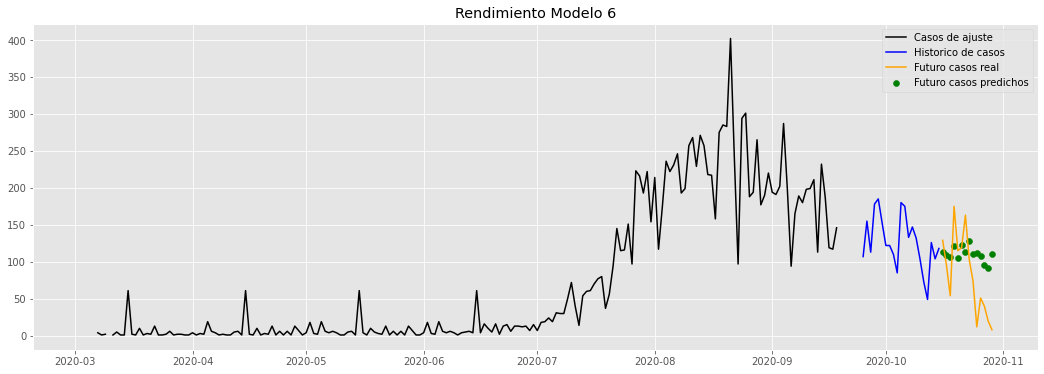

In [165]:
fig = plt.figure(figsize=(18,6))
plt.title('Rendimiento Modelo 6')
# plotear los valores de entrenamiento
plt.plot(final_data_train.index, A.values[:,col_to_predict], c='black', label='Casos de ajuste');
# plotear la última ventana
plt.plot(last_future_values_x.index, scaler.inverse_transform(last_future_values_x.values)[:,col_to_predict], c='blue', label='Historico de casos');
plt.plot(last_future_values_y.index, real_y_values_inverse, c='orange', label='Futuro casos real');
plt.scatter(last_future_values_y.index, predicted_y_values_inverse, c='green', label='Futuro casos predichos');
plt.legend()
plt.show();

In [104]:
# Guardar el mejor modelo y scaler
best_model_6.save('model_6/best_model_6.h5')
# save the scaler
pkl.dump(scaler, open('model_6/scaler_model_6.pkl', 'wb'))
# Guardar un archivo con el orden de los países
np.savetxt(fname='model_6/order_keys_list.txt',X=final_data_test.keys(),fmt='%s')

## Modelo 7 RNN autoregresivo sobre BUCARAMANGA

In [ ]:
def tf_data_to_numpy(tf_dataset):
    tf_dataset = tf_dataset.enumerate(start=0)
    for ind, (x, y) in tf_dataset:
        if ind == 0:
            X_train = x.numpy()
            y_train = y.numpy()
        else:    
            X_train = np.append(X_train, x.numpy(), axis=0)
            y_train = np.append(y_train, y.numpy(), axis=0)
    return X_train, y_train        